In [2]:
# %matplotlib ipympl

In [3]:
import torch
import numpy as np
import importlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from time import sleep, time
import sys
import os
DatasetPath = '../Dataset/' 
# append absolute DasetPath to path
DatasetPath = os.path.abspath(DatasetPath)
sys.path.append(DatasetPath)
import Dataset2 as DS

import pandas as pd

importlib.reload(DS)
DatasetContainer = DS.DatasetContainer
ProcessingDatasetContainer = DS.ProcessingDatasetContainer

def PLTParams(figsize = [10,10]):
    plt.rcParams['figure.figsize']=figsize
    plt.rcParams['font.size']=15
PLTParams()



sys.path.append(os.path.abspath('../CherenkovFraction/'))

# Add the ignore warnings
import warnings
warnings.filterwarnings("ignore")

hostname = os.uname()
if 'tedtop' in hostname: plt.style.use('/home/fedor-tairli/work/MPLStylefiles/Vscode_DarkModern_Invisible.mplstyle')

plt.style.use('default')


In [4]:
def IndexToXY(indices,return_tensor=False):
    indices = indices -1
    Xs = indices//22
    Ys = indices%22
    if return_tensor: return Xs.int(),Ys.int()
    else:             return Xs.int().tolist(),Ys.int().tolist()



#### Import Datasets

In [5]:
DataPath = os.path.abspath('../Data/Proccessed/')
print('DataPath:',DataPath)

DataPath: /home/fedor-tairli/work/CDEs/Data/Proccessed


In [6]:
# Importing Dataset
# Cause it takes a while to lad this thing introduce a check if its already laoded into globals
CheckGlobals = True 
LoadTraces = True

if CheckGlobals: 
    if 'Dataset' in globals():
        print('Dataset already loaded')
        if len(Dataset.Event_level_keys.keys())<1:
            print('Dataset Event_level_keys is None, reloading Dataset')
            Dataset.Load(DataPath,'CDEsDataset' ,LoadTraces=LoadTraces)
    else:
        print('Loading Dataset')
        Dataset = DatasetContainer()
        Dataset.Load(DataPath,'CDEsDataset' ,LoadTraces=LoadTraces)

# Unfuck the Dataset Keys, cuase the EventID string should have a capital D....
if 'EventId_1/2' in Dataset.Event_level_keys.keys():
    Dataset.Event_level_keys['EventID_1/2'] = Dataset.Event_level_keys.pop('EventId_1/2')
    Dataset.Event_level_keys['EventID_2/2'] = Dataset.Event_level_keys.pop('EventId_2/2')
    print('Replaced the EventID Keys, with proper ones')
else:
    print('EventID Keys already replaced')

Loading Dataset
Loading CDEsDataset
EventID Keys already replaced


In [7]:
print('Event level keys:')
for key in Dataset.Event_level_keys.keys(): print('    ',key)
print('Pixel level keys:')
for key in Dataset.Pixel_level_keys.keys(): print('    ',key)

Event level keys:
     EventID_1/2
     EventID_2/2
     Rec_Level
     Event_Class
     Primary
     Gen_LogE
     Gen_CosZenith
     Gen_Xmax
     Gen_dEdXmax
     Gen_SDPPhi
     Gen_SDPTheta
     Gen_Chi0
     Gen_Rp
     Gen_T0
     Gen_CoreEyeDist
     Gen_CherenkovFraction
     Rec_LogE
     Rec_CosZenith
     Rec_Xmax
     Rec_dEdXmax
     Rec_SDPPhi
     Rec_SDPTheta
     Rec_Chi0
     Rec_Rp
     Rec_T0
     Rec_CoreEyeDist
     Rec_CherenkovFraction
Pixel level keys:
     PixelID
     TelID
     EyeID
     Status
     Charge
     Theta
     Phi
     TimeOffset
     PulseStart
     PulseCentroid
     PulseStop


In [8]:
AllPossiblePixelDirections = pd.read_csv('../ReadingData/camera_view_table_with_HEAT_down.txt',sep=' ',header=None,names = ['EyeID','TelID','PixID','Theta','Phi'])

In [9]:
AllPossiblePixelDirections.head()

EyeID  TelID  PixID    Theta      Phi
0      1      1      1  1.61140  358.419
1      1      1      2  2.86980  359.174
2      1      1      3  4.13764  358.434
3      1      1      4  5.38773  359.205
4      1      1      5  6.66357  358.476

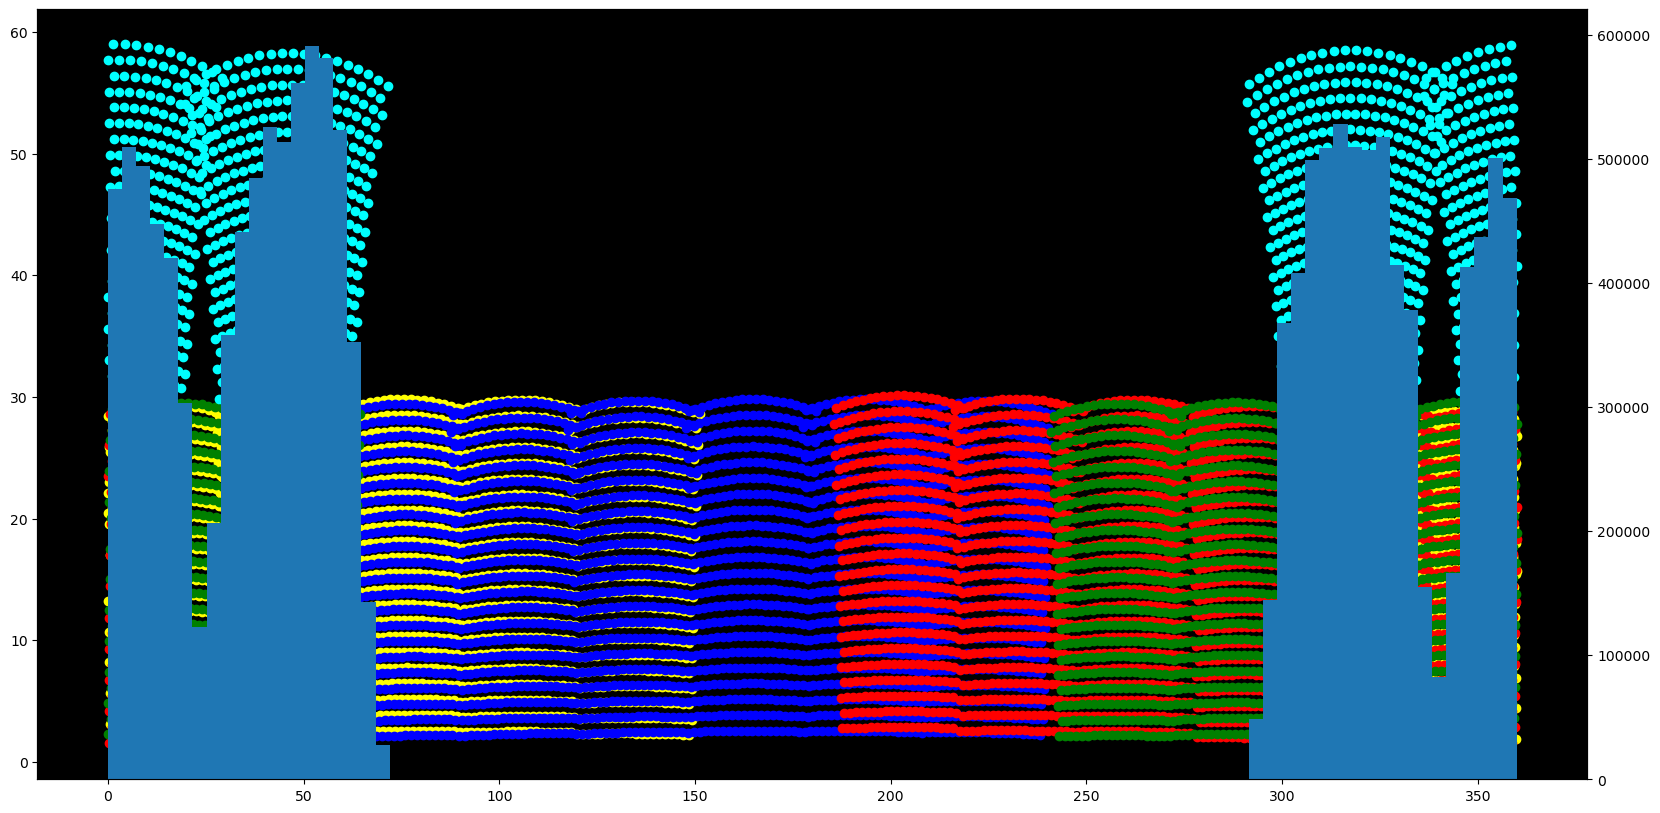

In [10]:
colors = ['yellow','blue','red','green','cyan']
plt.figure(figsize = [20,10])
plt.gca().set_facecolor('black')
for iEye in range(1,6):
    Mask = AllPossiblePixelDirections.EyeID == iEye
    Thetas = AllPossiblePixelDirections.Theta[Mask]
    Phis   = AllPossiblePixelDirections.Phi[Mask]
    plt.scatter(Phis,Thetas,c = colors[iEye-1])
    
ax2 = plt.gca().twinx()
CO_BackwallAngle = 243.0219
HE_BackwallAngle = 273.0
AllThetas = Dataset.get_pixel_values('Theta')
# plt.hist(AllThetas,bins=100)
AllPhis   = Dataset.get_pixel_values('Phi')
X = AllPhis+HE_BackwallAngle
X[X>360] -= 360
ax2.hist(X,bins=100)
plt.show()

In [11]:
event_class_labels = {
    0: 'Shower Candidate',
    1: 'Close Shower',
    2: 'Horizontal Shower',
    3: 'Large Event',
    4: 'Muon + Noise',
    5: 'Long Muon',
    6: 'Noise',
    7: 'Muon'
}

In [12]:
All_Event_Classes = Dataset.get_values('Event_Class').numpy()

for i in range(8):
    mask = All_Event_Classes == i
    print(f'Event Class {event_class_labels[i]} : {(np.sum(mask)/len(mask)*100):.3f} % events')

Event Class Shower Candidate : 10.114 % events
Event Class Close Shower : 32.292 % events
Event Class Horizontal Shower : 0.590 % events
Event Class Large Event : 0.001 % events
Event Class Muon + Noise : 36.433 % events
Event Class Long Muon : 11.020 % events
Event Class Noise : 1.445 % events
Event Class Muon : 8.103 % events


### Testing Rp distributions


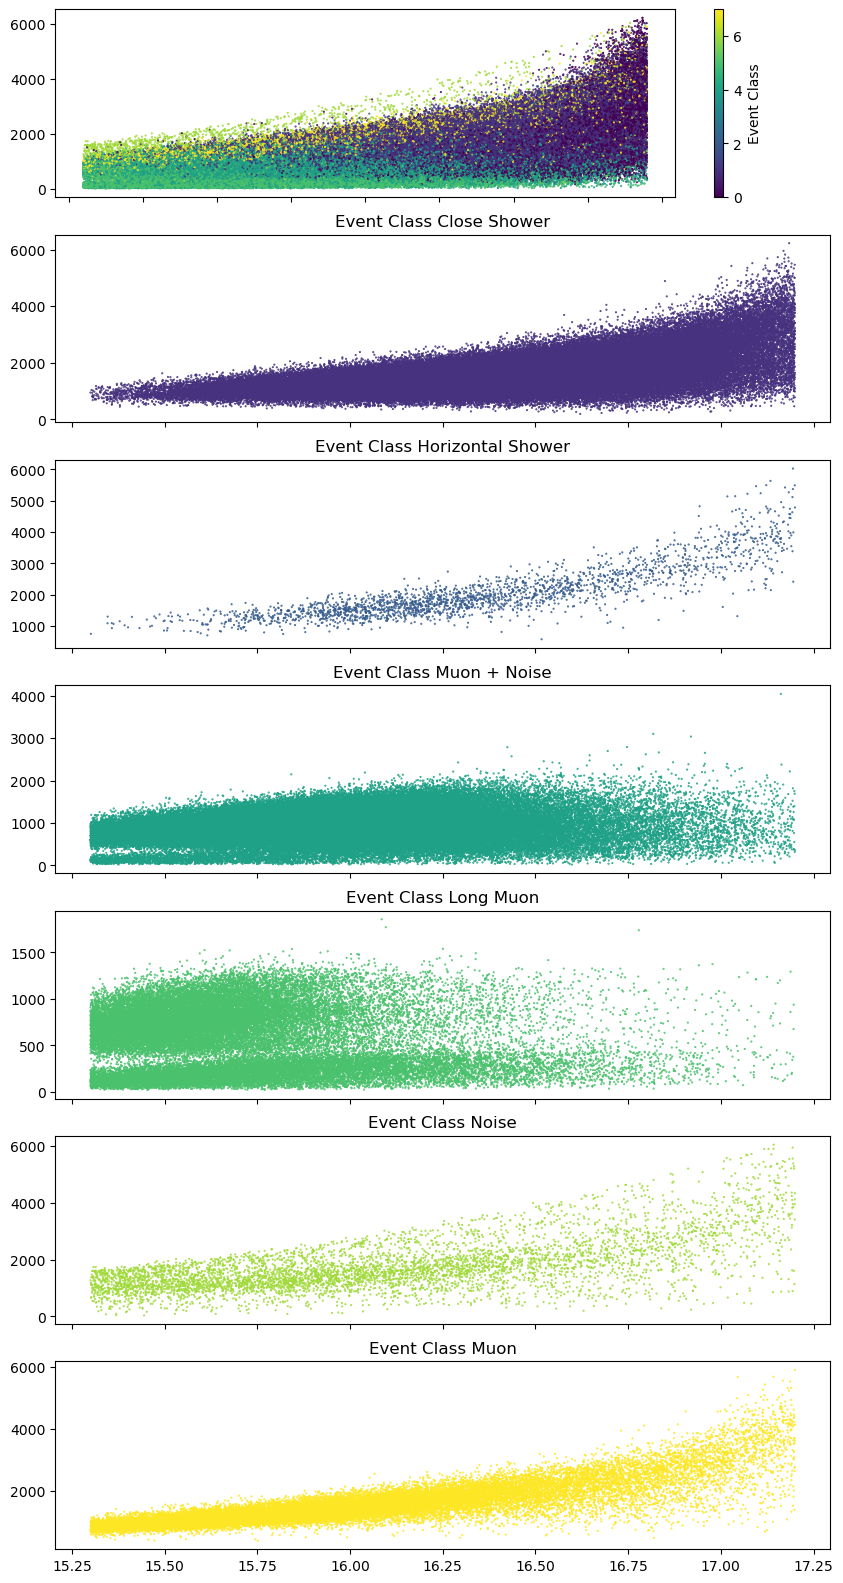

In [13]:
Gen_Rp   = Dataset.get_values('Gen_Rp').numpy()
Gen_LogE = Dataset.get_values('Gen_LogE').numpy()
Gen_CherenkovFraction = Dataset.get_values('Gen_CherenkovFraction').numpy()
EventCLass = Dataset.get_values('Event_Class').numpy()

cut = EventCLass < 10

Gen_Rp   = Gen_Rp[cut]
Gen_LogE = Gen_LogE[cut]
Gen_CherenkovFraction = Gen_CherenkovFraction[cut]
EventCLass = EventCLass[cut]

# plt.figure(figsize = [10,10])
# plt.scatter(Gen_LogE,Gen_Rp,c=EventCLass,marker='.',s=1)
# plt.colorbar(label='Cherenkov Fraction')
# # plt.ylim(0,1000)


fig, ax = plt.subplots(7,1,figsize=(10, 20), sharex=True)
ax[0].scatter(Gen_LogE,Gen_Rp,c=EventCLass,marker='.',s=1, vmin = 0, vmax = 7)
axN = 0
for i in range(1,9):
    if i == 3 or i == 8: continue
    axN += 1
    cut = EventCLass == i
    ax[axN].set_title(f'Event Class {event_class_labels[i]}')
    ax[axN].scatter(Gen_LogE[cut],Gen_Rp[cut],c=EventCLass[cut],marker='.',s=1, vmin = 0, vmax = 7)

plt.colorbar(ax[0].collections[0], ax=ax[0], label='Event Class')


#### Angular speed thing

In [14]:
all_omegas = []
all_cherenkov_fractions = []
all_Rps = []
all_logEs = []
all_event_classes = []

for i,event in enumerate(Dataset):
    event_pixels_Thetas = event.get_pixel_values('Theta')
    event_pixels_Phis   = event.get_pixel_values('Phi')
    event_pixels_Time   = event.get_pixel_values('PulseCentroid')
    event_pixels_status = event.get_pixel_values('Status')

    cut = event_pixels_status > 2
    event_pixels_Thetas = event_pixels_Thetas[cut]
    event_pixels_Phis   = event_pixels_Phis[cut]
    event_pixels_Time   = event_pixels_Time[cut]
    event_pixels_status = event_pixels_status[cut]

    # print(event_pixels_Thetas)
    # print(event_pixels_Phis)
    # print(event_pixels_Time)
    # print(event_pixels_status)

    # convert Thetas and Phis to 3vectors
    event_pixels_directions = torch.stack([
        torch.sin(event_pixels_Thetas*torch.pi/180) * torch.cos(event_pixels_Phis*torch.pi/180),
        torch.sin(event_pixels_Thetas*torch.pi/180) * torch.sin(event_pixels_Phis*torch.pi/180),
        torch.cos(event_pixels_Thetas*torch.pi/180)
    ]).T
    print(event_pixels_directions.shape)
    # calculate the angel between each of the pixel pairs
    dot_products = event_pixels_directions @ event_pixels_directions.T
    print(dot_products.shape)
    angles = torch.acos(torch.clamp(dot_products, -1.0, 1.0))
    print(angles.shape)
    time_diffs = event_pixels_Time[:, None] - event_pixels_Time[None, :]
    print(time_diffs.shape)
    cut = (time_diffs > 0) + torch.isnan(time_diffs) + torch.isinf(time_diffs)
    omegas = angles / time_diffs
    print(omegas)
    print(cut)

    omegas = omegas[cut]
    print(omegas)
 


    if i ==0:break

torch.Size([8, 3])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
tensor([[    nan, -0.0525, -0.1200, -0.1361, -0.0365, -0.0403, -0.0438, -0.0352],
        [ 0.0525,     inf,  0.0467,  0.0380, -0.0264, -0.0329, -0.0398, -0.0304],
        [ 0.1200, -0.0467,     inf, -0.7679, -0.0284, -0.0359, -0.0409, -0.0321],
        [ 0.1361, -0.0380,  0.7679,     inf, -0.0311, -0.0330, -0.0371, -0.0309],
        [ 0.0365,  0.0264,  0.0284,  0.0311,     nan, -0.0635, -0.0633, -0.0349],
        [ 0.0403,  0.0329,  0.0359,  0.0330,  0.0635,     nan, -0.0633, -0.0284],
        [ 0.0438,  0.0398,  0.0409,  0.0371,  0.0633,  0.0633,     nan, -0.0226],
        [ 0.0352,  0.0304,  0.0321,  0.0309,  0.0349,  0.0284,  0.0226,     inf]])
tensor([[False, False, False, False, False, False, False, False],
        [ True, False,  True,  True, False, False, False, False],
        [ True, False, False, False, False, False, False, False],
        [ True, False,  True, False, False, False, False, False],
   

In [15]:
for i,event in enumerate(Dataset):
    if i > 10: break
    print(event.get_pixel_values('PulseCentroid'))

tensor([  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000, 292.1780,
        292.8400,   0.0000, 292.3240,   0.0000,   0.0000,   0.0000,   0.0000,
        292.3560,   0.0000, 293.5360, 293.9140,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
        294.2950,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000, 295.1810,   0.0000,
          0.0000,   0.0000,   0.0000, 299.6450,   0.0000,   0.0000,   0.0000,
          0.0000, 186.0250,   0.0000,   0.0000,   0.0000, 743.9970,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000])
tensor([  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000, 306.2900, 303.3620,   0.0000,   0.0000, 304.0010,   0.0000,
          0.0000, 304.8250,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
        306.4460,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0

In [16]:
all_omegas = []
all_durations = []
all_multiplicities = []
all_cherenkov_fractions = []
all_Rps = []
all_logEs = []
all_Xmaxs = []
all_event_classes = []

for i,event in enumerate(Dataset):
    event_pixels_Thetas = event.get_pixel_values('Theta')
    event_pixels_Phis   = event.get_pixel_values('Phi')
    event_pixels_Time   = event.get_pixel_values('PulseCentroid')
    event_pixels_status = event.get_pixel_values('Status')

    cut = event_pixels_status == 4
    if sum(cut) < 2:
        # print(f'Event {i} has less than 2 pixels with status 4, skipping')
        continue
    event_pixels_Thetas = event_pixels_Thetas[cut]
    event_pixels_Phis   = event_pixels_Phis[cut]
    event_pixels_Time   = event_pixels_Time[cut]
    event_pixels_status = event_pixels_status[cut]

    # Calculate the average angular velocity
    first_pixel_i = torch.argmin(event_pixels_Time)
    last_pixel_i  = torch.argmax(event_pixels_Time)

    first_pixel_theta = event_pixels_Thetas[first_pixel_i]
    first_pixel_phi   = event_pixels_Phis[first_pixel_i]
    last_pixel_theta  = event_pixels_Thetas[last_pixel_i]
    last_pixel_phi    = event_pixels_Phis[last_pixel_i]

    first_pixel_direction = torch.tensor([
        torch.sin(first_pixel_theta*torch.pi/180) * torch.cos(first_pixel_phi*torch.pi/180),
        torch.sin(first_pixel_theta*torch.pi/180) * torch.sin(first_pixel_phi*torch.pi/180),
        torch.cos(first_pixel_theta*torch.pi/180)
    ])
    last_pixel_direction = torch.tensor([
        torch.sin(last_pixel_theta*torch.pi/180) * torch.cos(last_pixel_phi*torch.pi/180),
        torch.sin(last_pixel_theta*torch.pi/180) * torch.sin(last_pixel_phi*torch.pi/180),
        torch.cos(last_pixel_theta*torch.pi/180)
    ])

    angle = torch.acos(torch.clamp(torch.dot(first_pixel_direction, last_pixel_direction), -1.0, 1.0))
    time_diff = event_pixels_Time[last_pixel_i] - event_pixels_Time[first_pixel_i]
    omega = angle / time_diff if time_diff > 0 else 0

    # print(f'Event {i}: Omega = {omega:.4f} rad/s')


    # Store the values
    all_omegas.append(omega.item())
    all_durations.append(time_diff.item())
    all_multiplicities.append(sum(cut))
    all_cherenkov_fractions.append(event.get_value('Gen_CherenkovFraction'))
    all_Rps.append(event.get_value('Gen_Rp'))
    all_logEs.append(event.get_value('Gen_LogE'))
    all_Xmaxs.append(event.get_value('Gen_Xmax'))
    all_event_classes.append(event.get_value('Event_Class'))

    # if i > 100000: break
all_omegas = np.array(all_omegas)
all_durations = np.array(all_durations)
all_multiplicities = np.array(all_multiplicities)
all_cherenkov_fractions = np.array(all_cherenkov_fractions)
all_Rps = np.array(all_Rps)
all_logEs = np.array(all_logEs)
all_Xmaxs = np.array(all_Xmaxs)
all_event_classes = np.array(all_event_classes)



Text(0.5, 1.0, 'Omega vs Cherenkov Fraction')

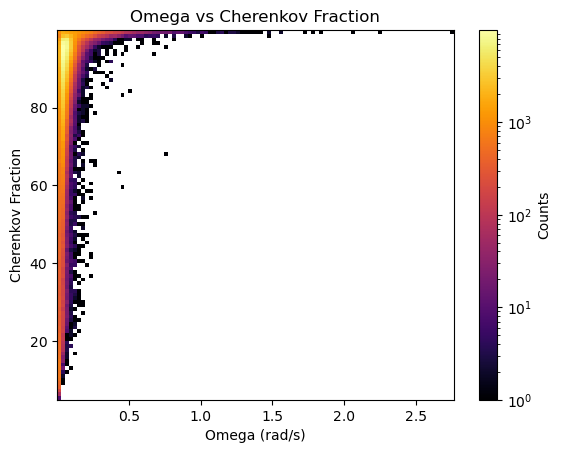

In [17]:
plt.hist2d(all_omegas,all_cherenkov_fractions, bins=100, cmap='inferno', norm=mcolors.LogNorm())
plt.colorbar(label='Counts')
plt.xlabel('Omega (rad/s)')
plt.ylabel('Cherenkov Fraction')
plt.title('Omega vs Cherenkov Fraction')

Cutting at Omega = 0.0632 rad/s


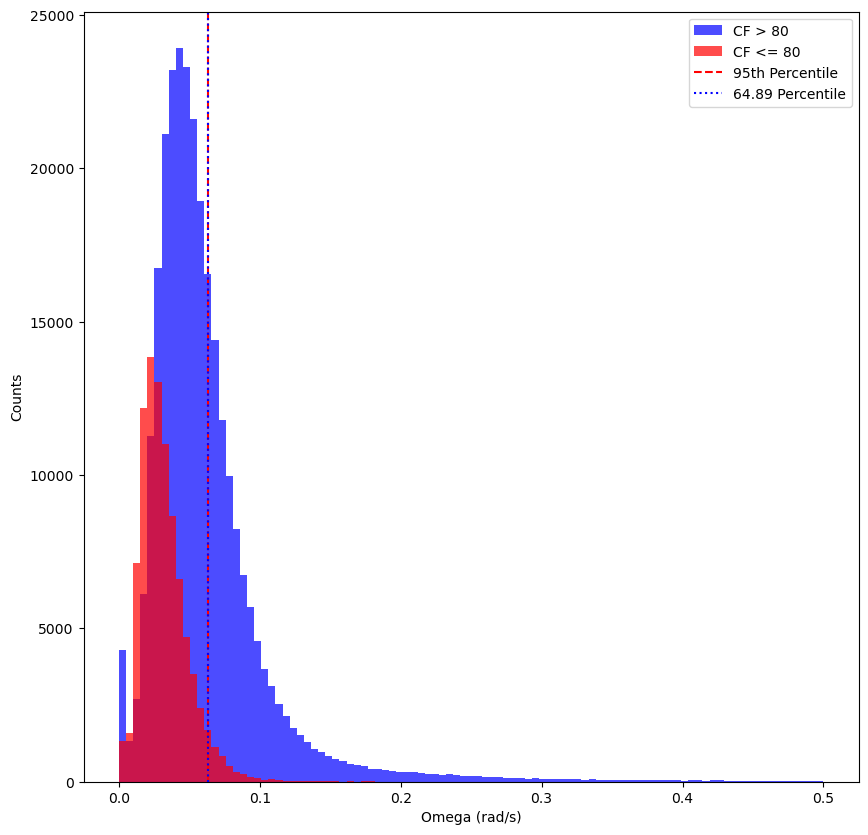

In [18]:

CF_th = 80
plt.figure(figsize=(10, 10))
plt.hist(all_omegas[all_cherenkov_fractions > CF_th], bins = np.linspace(0,0.5,100), color='blue', alpha=0.7, label=f'CF > {CF_th}')
plt.hist(all_omegas[all_cherenkov_fractions <= CF_th], bins = np.linspace(0,0.5,100), color='red', alpha=0.7, label=f'CF <= {CF_th}')
plt.xlabel('Omega (rad/s)')
plt.ylabel('Counts')
plt.axvline(x = np.percentile(all_omegas[all_cherenkov_fractions <= CF_th], 95), color='red', linestyle='--', label='95th Percentile')
fraction_CF = np.sum(all_omegas[all_cherenkov_fractions > CF_th] < np.percentile(all_omegas[all_cherenkov_fractions <= CF_th], 95)) / len(all_omegas[all_cherenkov_fractions > CF_th])
plt.axvline(x = np.percentile(all_omegas[all_cherenkov_fractions <= CF_th], 95), color='blue', linestyle=':', label=f'{fraction_CF*100:.2f} Percentile')

print(f'Cutting at Omega = {np.percentile(all_omegas[all_cherenkov_fractions <= CF_th], 95):.4f} rad/s')
plt.legend()



Text(0.5, 0, 'Rp (g/cm^2)')

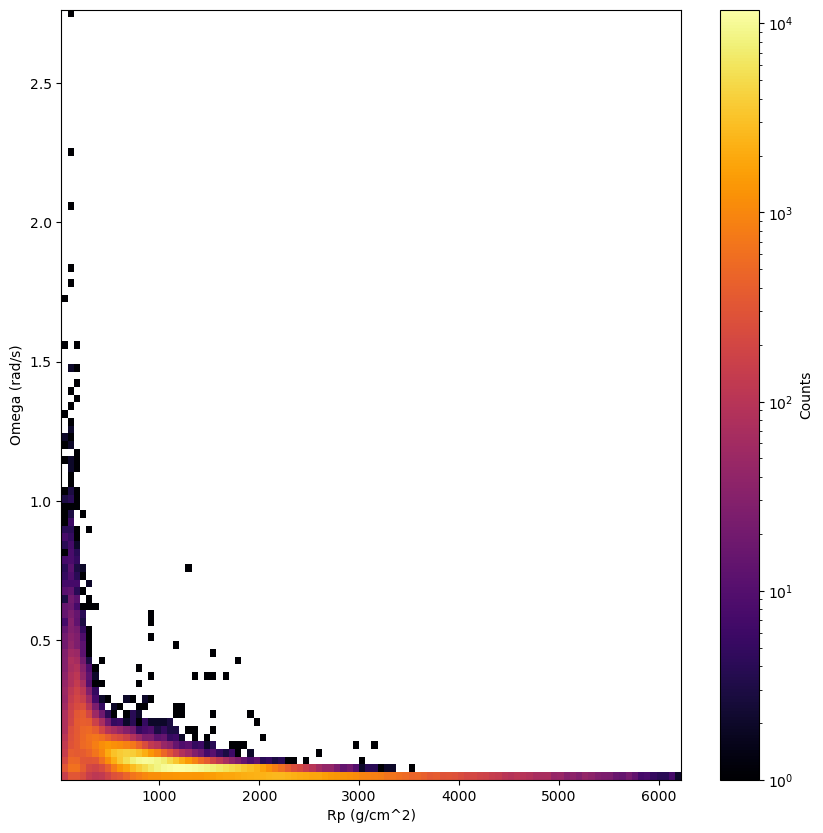

In [19]:
plt.figure(figsize=(10, 10))
plt.hist2d( all_Rps, all_omegas, bins=100, cmap='inferno', norm=mcolors.LogNorm())
plt.colorbar(label='Counts')
plt.ylabel('Omega (rad/s)')
plt.xlabel('Rp (g/cm^2)')

Cutting at Omega = 0.0630 rad/s


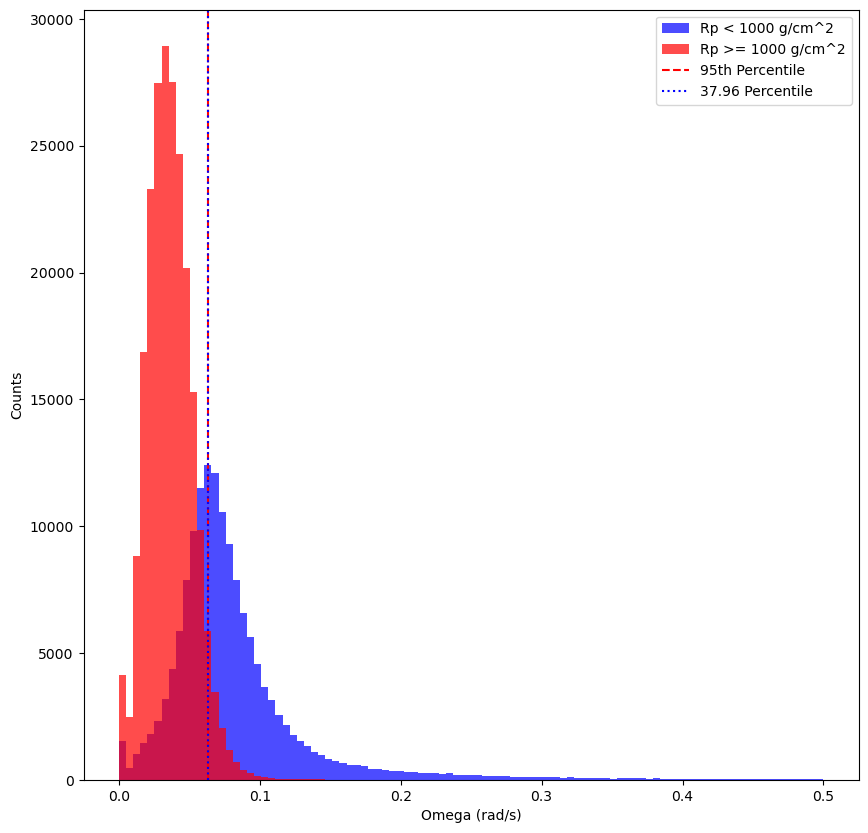

In [20]:

Rp_th = 1000
plt.figure(figsize=(10, 10))
plt.hist(all_omegas[all_Rps<Rp_th], bins = np.linspace(0,0.5,100), color='blue', alpha=0.7, label=f'Rp < {Rp_th} g/cm^2')
plt.hist(all_omegas[all_Rps>=Rp_th], bins = np.linspace(0,0.5,100), color='red', alpha=0.7, label=f'Rp >= {Rp_th} g/cm^2')
plt.xlabel('Omega (rad/s)')
plt.ylabel('Counts')
plt.axvline(x = np.percentile(all_omegas[all_Rps>=Rp_th], 95), color='red', linestyle='--', label='95th Percentile')
# find what fraction is this axvilne in the all_omegas[all_Rps<Rp_th]
fraction = np.sum(all_omegas[all_Rps<=Rp_th] < np.percentile(all_omegas[all_Rps>=Rp_th], 95)) / len(all_omegas[all_Rps<Rp_th])
plt.axvline(x = np.percentile(all_omegas[all_Rps>=Rp_th], 95), color='blue', linestyle=':',label = f'{fraction*100:.2f} Percentile')
plt.legend()

print(f'Cutting at Omega = {np.percentile(all_omegas[all_Rps>=Rp_th], 95):.4f} rad/s')


Text(0, 0.5, 'Omega (rad/s)')

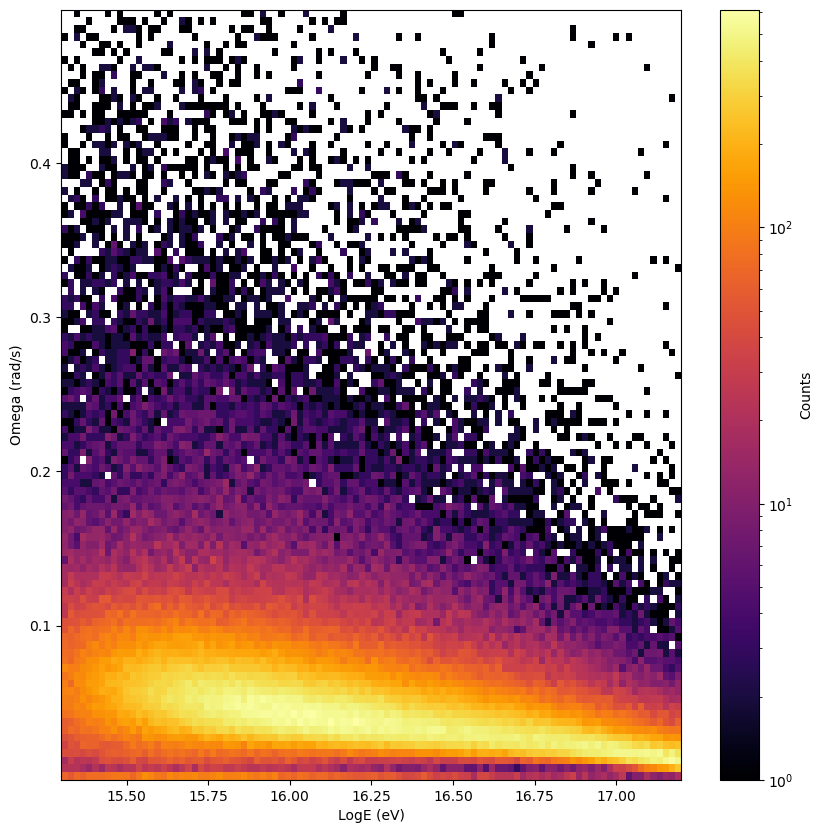

In [21]:
plt.figure(figsize=(10, 10))
plt.hist2d(all_logEs[all_omegas<0.5], all_omegas[all_omegas<0.5], bins = 100, cmap='inferno', norm=mcolors.LogNorm())
plt.colorbar(label='Counts')
plt.xlabel('LogE (eV)')
plt.ylabel('Omega (rad/s)')


Text(0, 0.5, 'Omega (rad/s)')

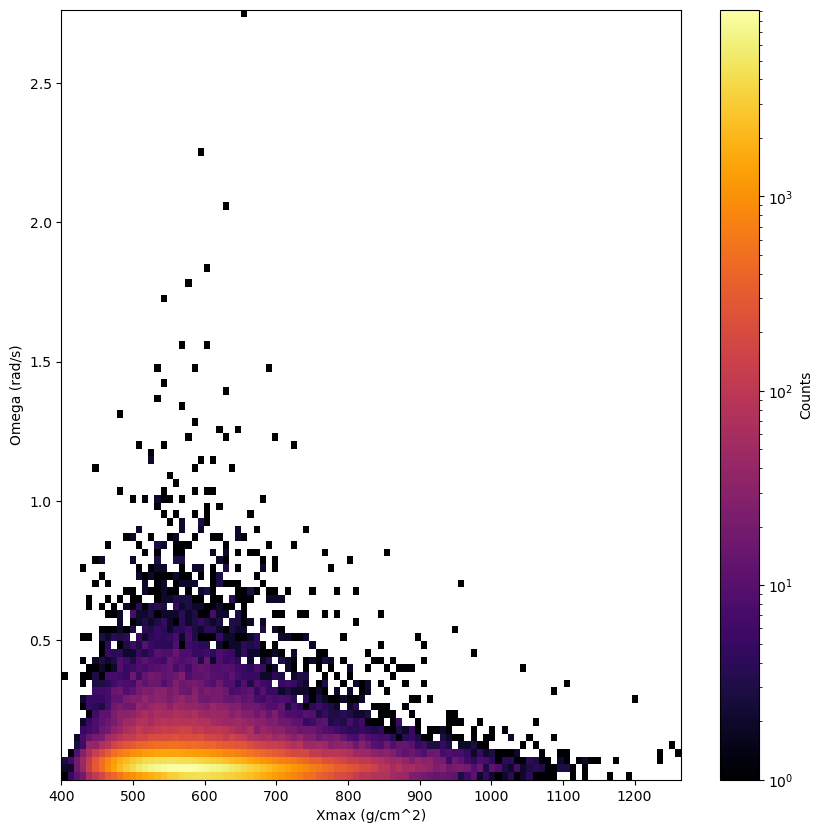

In [22]:
plt.figure(figsize=(10, 10))
plt.hist2d(all_Xmaxs, all_omegas, bins = 100, cmap='inferno', norm=mcolors.LogNorm())
plt.colorbar(label='Counts')
plt.xlabel('Xmax (g/cm^2)')
plt.ylabel('Omega (rad/s)')

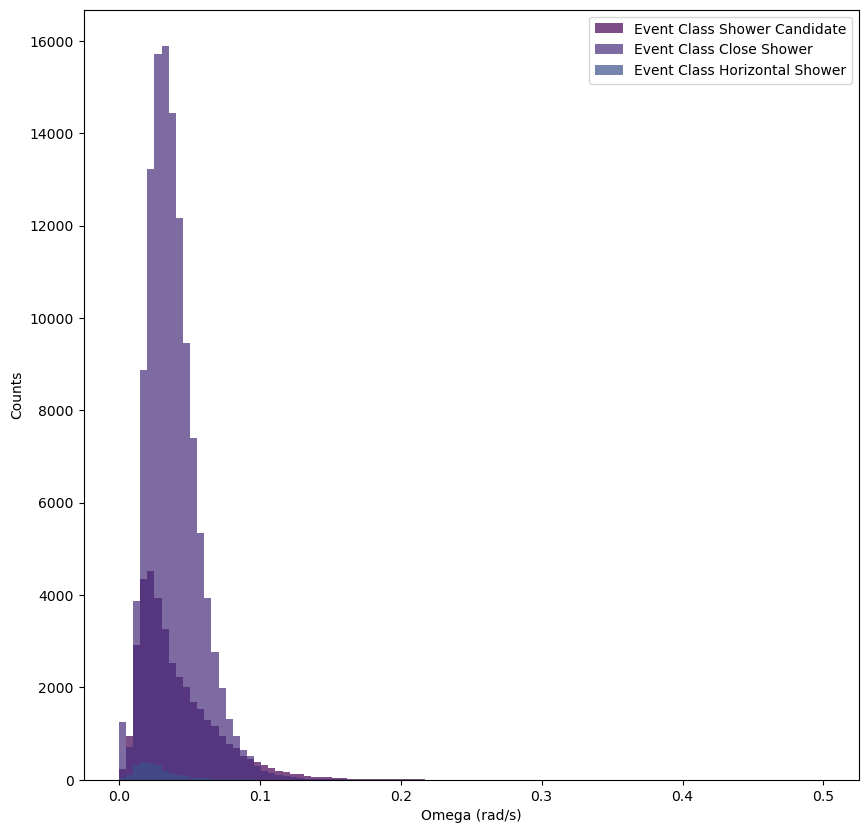

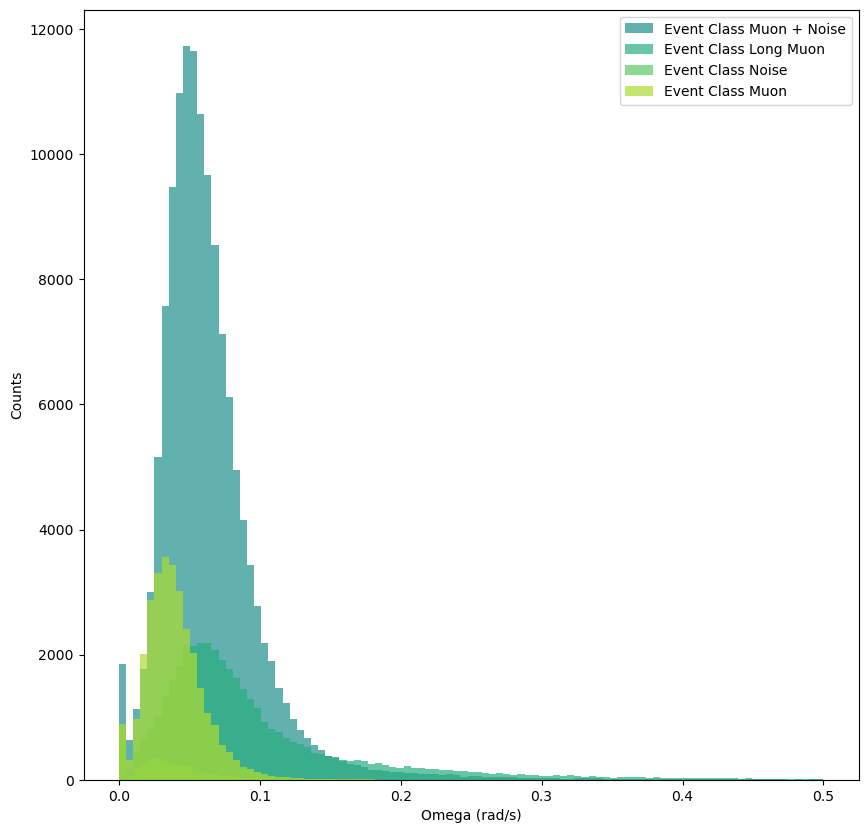

In [23]:
plt.figure(figsize=(10,10))

for EvClass in [0,1,2]:
    these_omegas = all_omegas[all_event_classes == EvClass]
    # color = picked out of viridis colormap with min=0 and max = 8
    color = plt.cm.viridis(EvClass / 8)  # Normalize EvClass to [0, 1] for colormap
    plt.hist(these_omegas, bins = np.linspace(0,0.5,100), label=f'Event Class {event_class_labels[EvClass]}', alpha=0.7,color = color)
plt.xlabel('Omega (rad/s)')
plt.ylabel('Counts')
# plt.yscale('log')
plt.legend()

plt.figure(figsize=(10,10))

for EvClass in [4,5,6,7]:
    these_omegas = all_omegas[all_event_classes == EvClass]
    # color = picked out of viridis colormap with min=0 and max = 8
    color = plt.cm.viridis(EvClass / 8)  # Normalize EvClass to [0, 1] for colormap
    plt.hist(these_omegas, bins = np.linspace(0,0.5,100), label=f'Event Class {event_class_labels[EvClass]}', alpha=0.7,color = color)
plt.xlabel('Omega (rad/s)')
plt.ylabel('Counts')
# plt.yscale('log')
plt.legend()

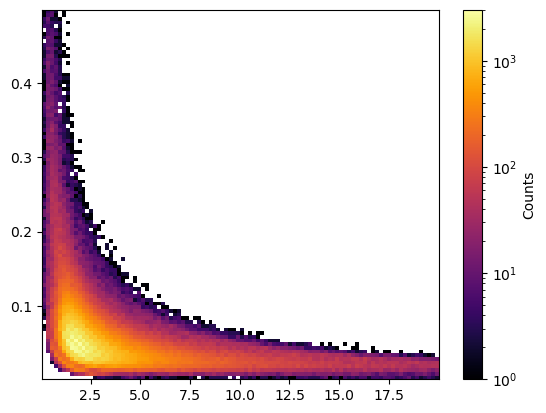

In [24]:
mask = (all_durations < 20) * (all_omegas<0.5)
plt.figure()
plt.hist2d(all_durations[mask],all_omegas[mask], bins=100, cmap='inferno', norm=mcolors.LogNorm())
plt.colorbar(label='Counts')

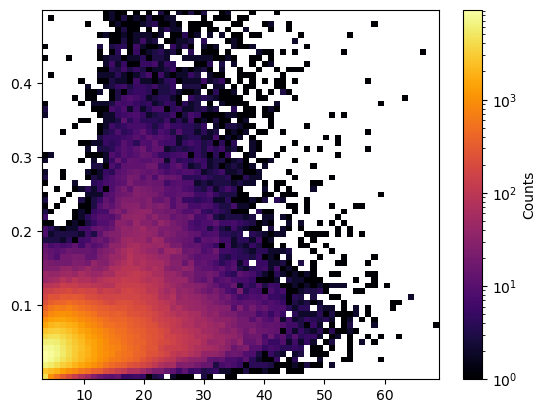

In [25]:
mask = (all_omegas<0.5)
plt.figure()
plt.hist2d(all_multiplicities[mask],all_omegas[mask], bins=65, cmap='inferno', norm=mcolors.LogNorm())
plt.colorbar(label='Counts')

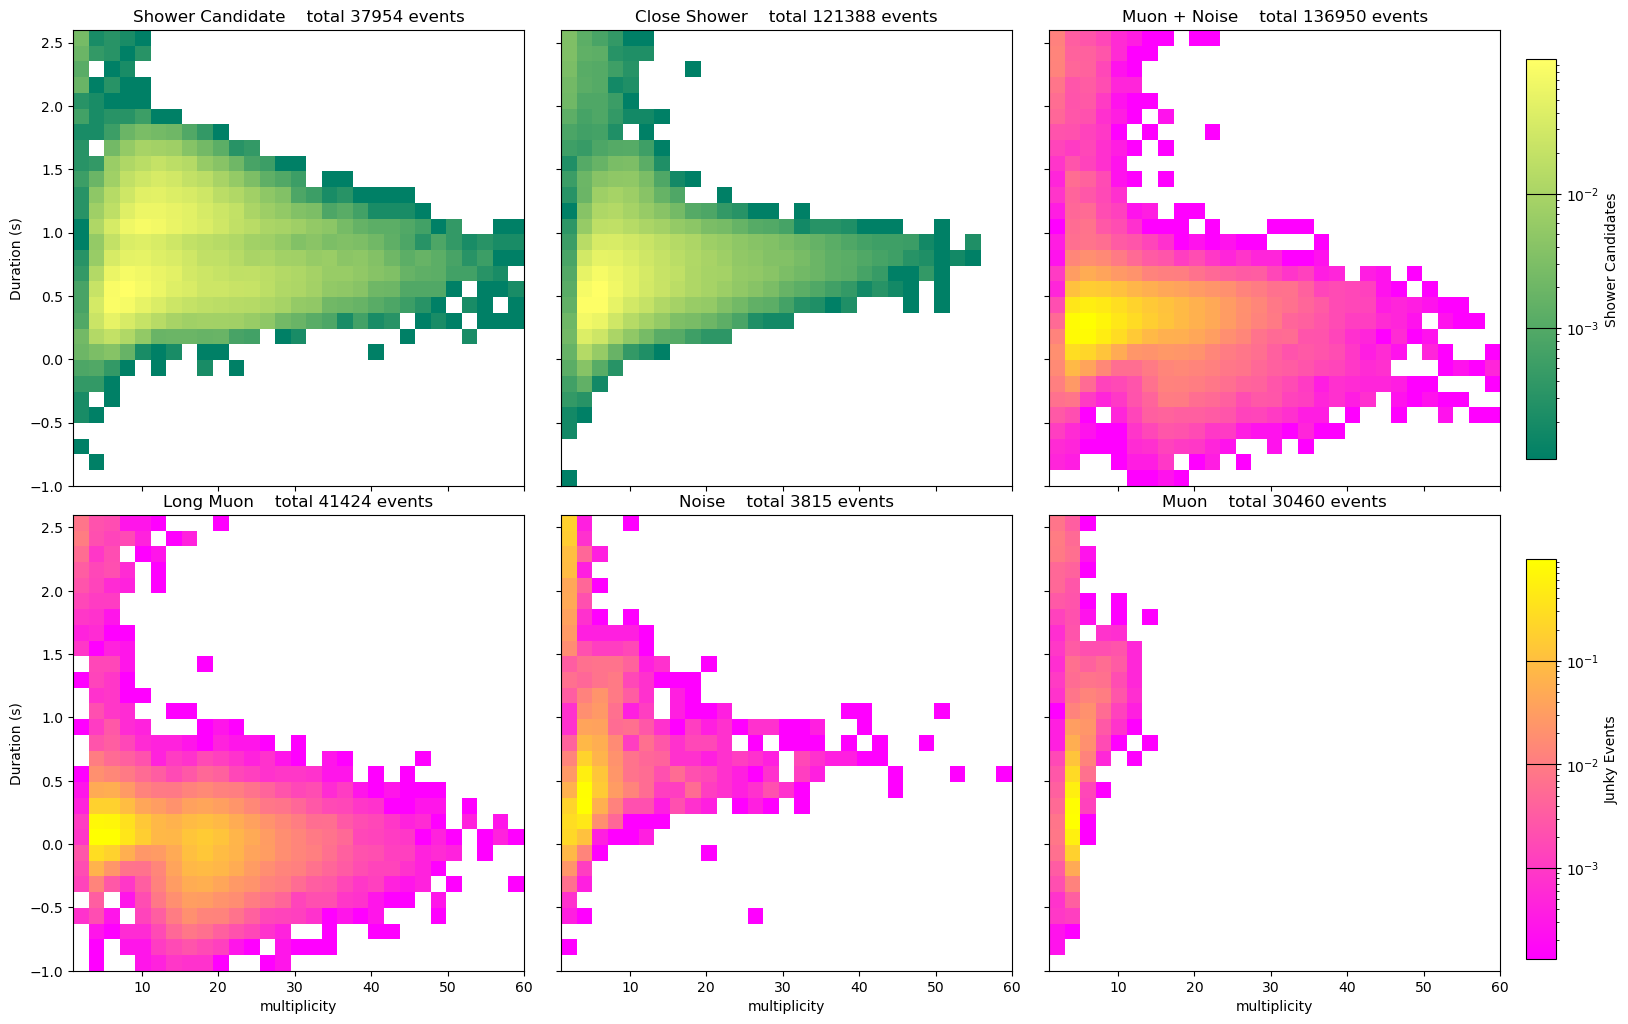

In [26]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
ax = ax.flatten()
plt.tight_layout()

# Create two new axes for colorbars to the right of the plot
cbar_ax1 = fig.add_axes([1, 0.55, 0.02, 0.4])  # [left, bottom, width, height]
cbar_ax2 = fig.add_axes([1, 0.05 , 0.02, 0.4])

im1 = None
im2 = None
for i, EvClass in enumerate([0, 1, 4, 5, 6, 7]):
    mask = (all_event_classes == EvClass)
    cmap = 'summer' if EvClass < 3 else 'spring'
    im = ax[i].hist2d(
        all_multiplicities[mask],
        np.log10(all_durations[mask]),
        bins=[np.linspace(1, 60, 30), np.linspace(-1, 2.6, 30)],
        cmap=cmap, norm=mcolors.LogNorm(), density=True
    )
    # Save the first and last image for colorbars
    if i == 0:
        im1 = im
    if i == 5:
        im2 = im
    if i in [0, 3]: ax[i].set_ylabel('Duration (s)')
    if i in [3, 4, 5]: ax[i].set_xlabel('multiplicity')
    ax[i].set_title(f'{event_class_labels[EvClass]}    total {np.sum(mask)} events')

# Add colorbars to the new axes
fig.colorbar(im1[3], cax=cbar_ax1, label='Shower Candidates')
fig.colorbar(im2[3], cax=cbar_ax2, label='Junky Events')
cbar_ax1.grid('major',color = 'k')
cbar_ax2.grid('major',color = 'k')

In [27]:
omega_threshold = 0.063
# Get mask for events with omega > threshold
mask = all_omegas > omega_threshold
# Get event classes for those events
classes_above_threshold = all_event_classes[mask]
# Calculate percentage for each class
unique_classes, counts = np.unique(classes_above_threshold, return_counts=True)
percentages = {event_class_labels[int(cls)]: count / len(classes_above_threshold) * 100 for cls, count in zip(unique_classes, counts)}
print(f"Percentages of event classes with omega > {omega_threshold}:")
for label, pct in percentages.items():
    print(f"{label}: {pct:.2f}%")

Percentages of event classes with omega > 0.063:
Shower Candidate: 6.87%
Close Shower: 10.57%
Horizontal Shower: 0.09%
Large Event: 0.00%
Muon + Noise: 54.18%
Long Muon: 24.40%
Noise: 0.43%
Muon: 3.46%


In [28]:
all_omegas = []
all_durations = []
all_multiplicities = []
all_cherenkov_fractions = []
all_Rps = []
all_logEs = []
all_myEpreds = []
all_Xmaxs = []
all_event_classes = []

for i,event in enumerate(Dataset):
    event_pixels_Thetas = event.get_pixel_values('Theta')
    event_pixels_Phis   = event.get_pixel_values('Phi')
    event_pixels_Time   = event.get_pixel_values('PulseCentroid')
    event_pixels_status = event.get_pixel_values('Status')

    cut = event_pixels_status == 4
    if sum(cut) < 2:
        # print(f'Event {i} has less than 2 pixels with status 4, skipping')
        continue
    event_pixels_Thetas = event_pixels_Thetas[cut]
    event_pixels_Phis   = event_pixels_Phis[cut]
    event_pixels_Time   = event_pixels_Time[cut]
    event_pixels_status = event_pixels_status[cut]

    # Calculate the average angular velocity
    first_pixel_i = torch.argmin(event_pixels_Time)
    last_pixel_i  = torch.argmax(event_pixels_Time)

    first_pixel_theta = event_pixels_Thetas[first_pixel_i]
    first_pixel_phi   = event_pixels_Phis[first_pixel_i]
    last_pixel_theta  = event_pixels_Thetas[last_pixel_i]
    last_pixel_phi    = event_pixels_Phis[last_pixel_i]

    first_pixel_direction = torch.tensor([
        torch.sin(first_pixel_theta*torch.pi/180) * torch.cos(first_pixel_phi*torch.pi/180),
        torch.sin(first_pixel_theta*torch.pi/180) * torch.sin(first_pixel_phi*torch.pi/180),
        torch.cos(first_pixel_theta*torch.pi/180)
    ])
    last_pixel_direction = torch.tensor([
        torch.sin(last_pixel_theta*torch.pi/180) * torch.cos(last_pixel_phi*torch.pi/180),
        torch.sin(last_pixel_theta*torch.pi/180) * torch.sin(last_pixel_phi*torch.pi/180),
        torch.cos(last_pixel_theta*torch.pi/180)
    ])

    angle = torch.acos(torch.clamp(torch.dot(first_pixel_direction, last_pixel_direction), -1.0, 1.0))
    time_diff = event_pixels_Time[last_pixel_i] - event_pixels_Time[first_pixel_i]
    omega = angle / time_diff if time_diff > 0 else 0

    # print(f'Event {i}: Omega = {omega:.4f} rad/s')
    MyEpred = event.get_trace_values().sum()


    # Store the values
    all_omegas.append(omega.item())
    all_durations.append(time_diff.item())
    all_multiplicities.append(sum(cut))
    all_cherenkov_fractions.append(event.get_value('Gen_CherenkovFraction'))
    all_Rps.append(event.get_value('Gen_Rp'))
    all_logEs.append(event.get_value('Gen_LogE'))
    all_myEpreds.append(MyEpred.item())
    all_Xmaxs.append(event.get_value('Gen_Xmax'))
    all_event_classes.append(event.get_value('Event_Class'))

    # if i > 100000: break
all_omegas = np.array(all_omegas)
all_durations = np.array(all_durations)
all_multiplicities = np.array(all_multiplicities)
all_cherenkov_fractions = np.array(all_cherenkov_fractions)
all_Rps = np.array(all_Rps)
all_logEs = np.array(all_logEs)
all_myEpreds = np.array(all_myEpreds)
all_Xmaxs = np.array(all_Xmaxs)
all_event_classes = np.array(all_event_classes)



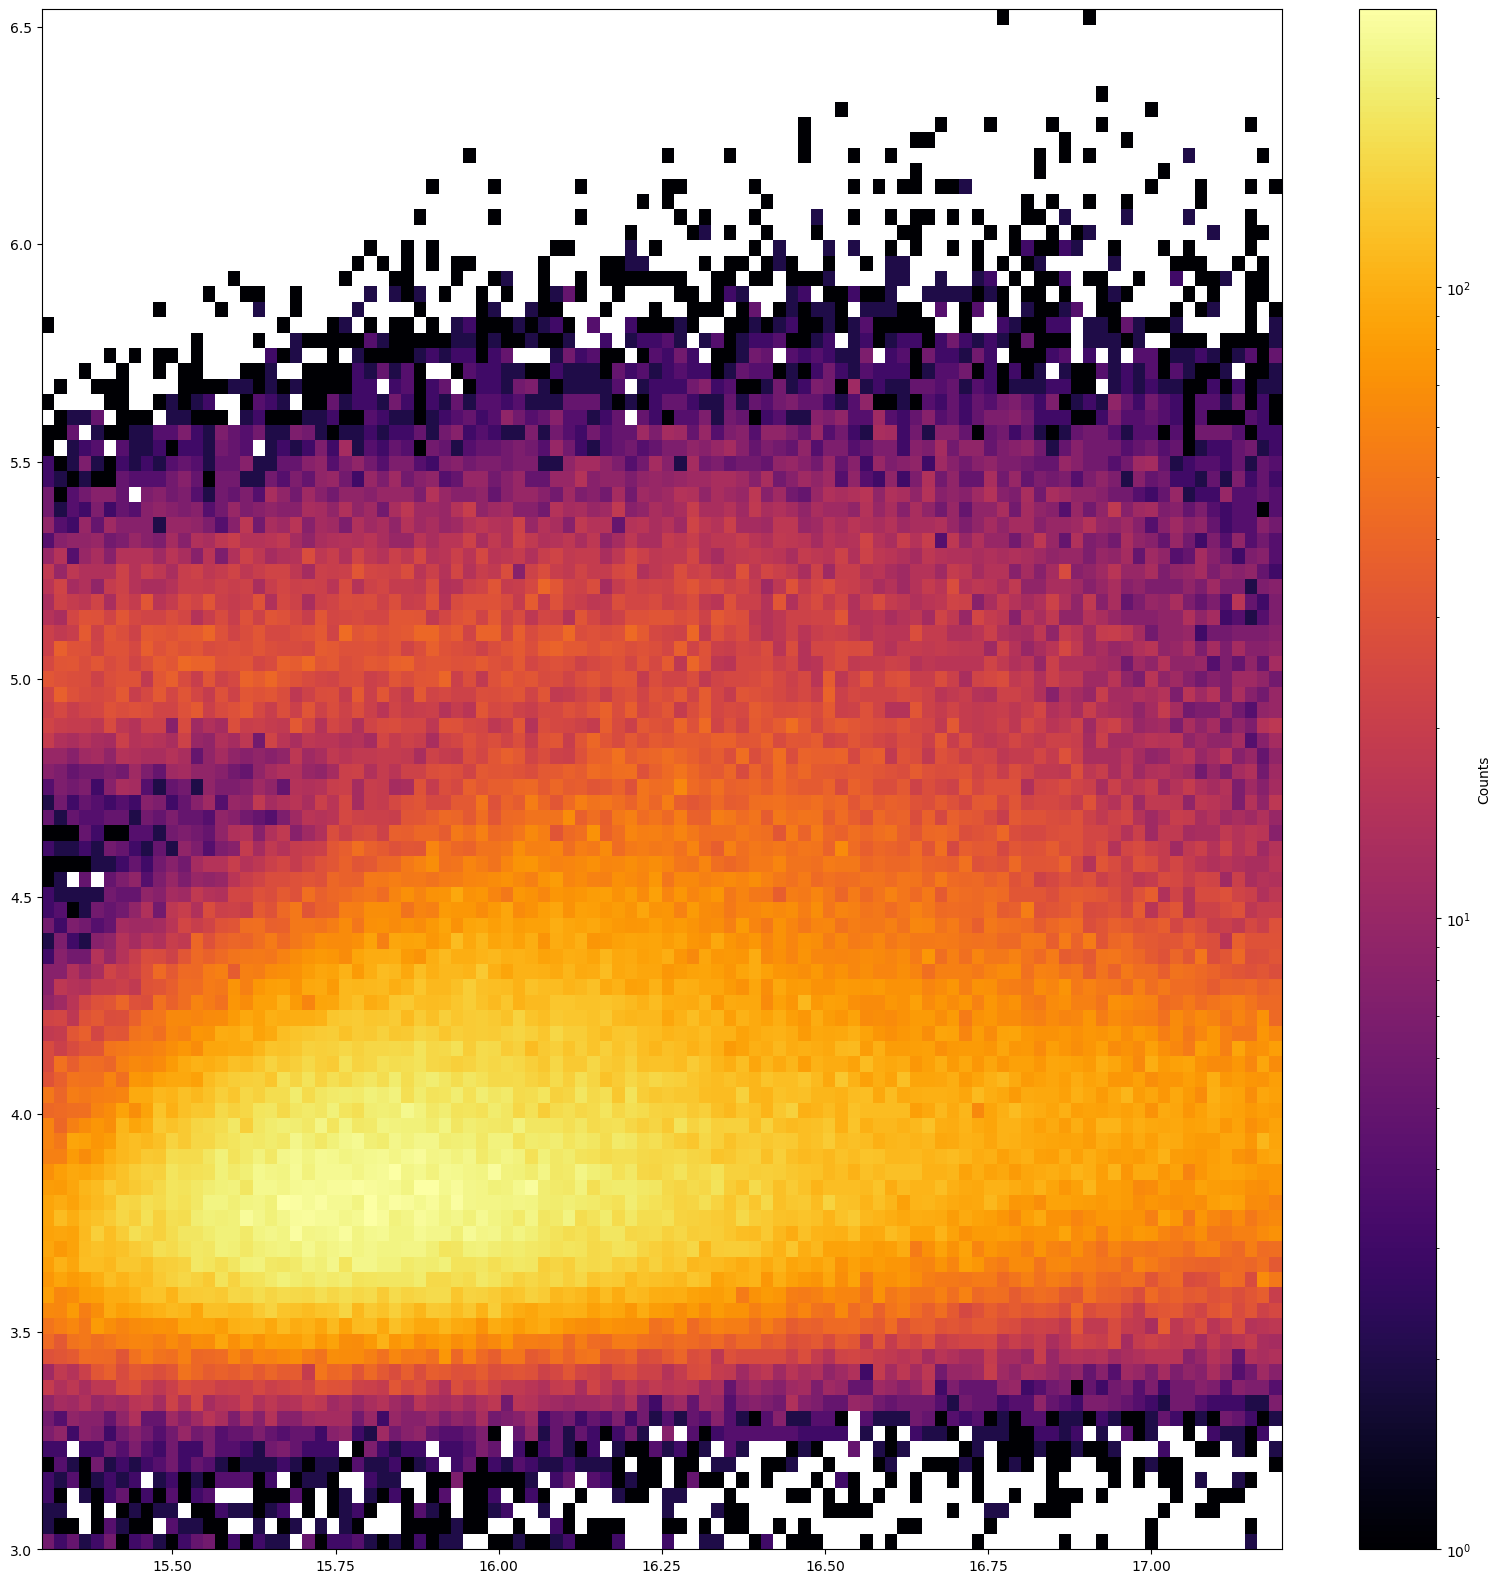

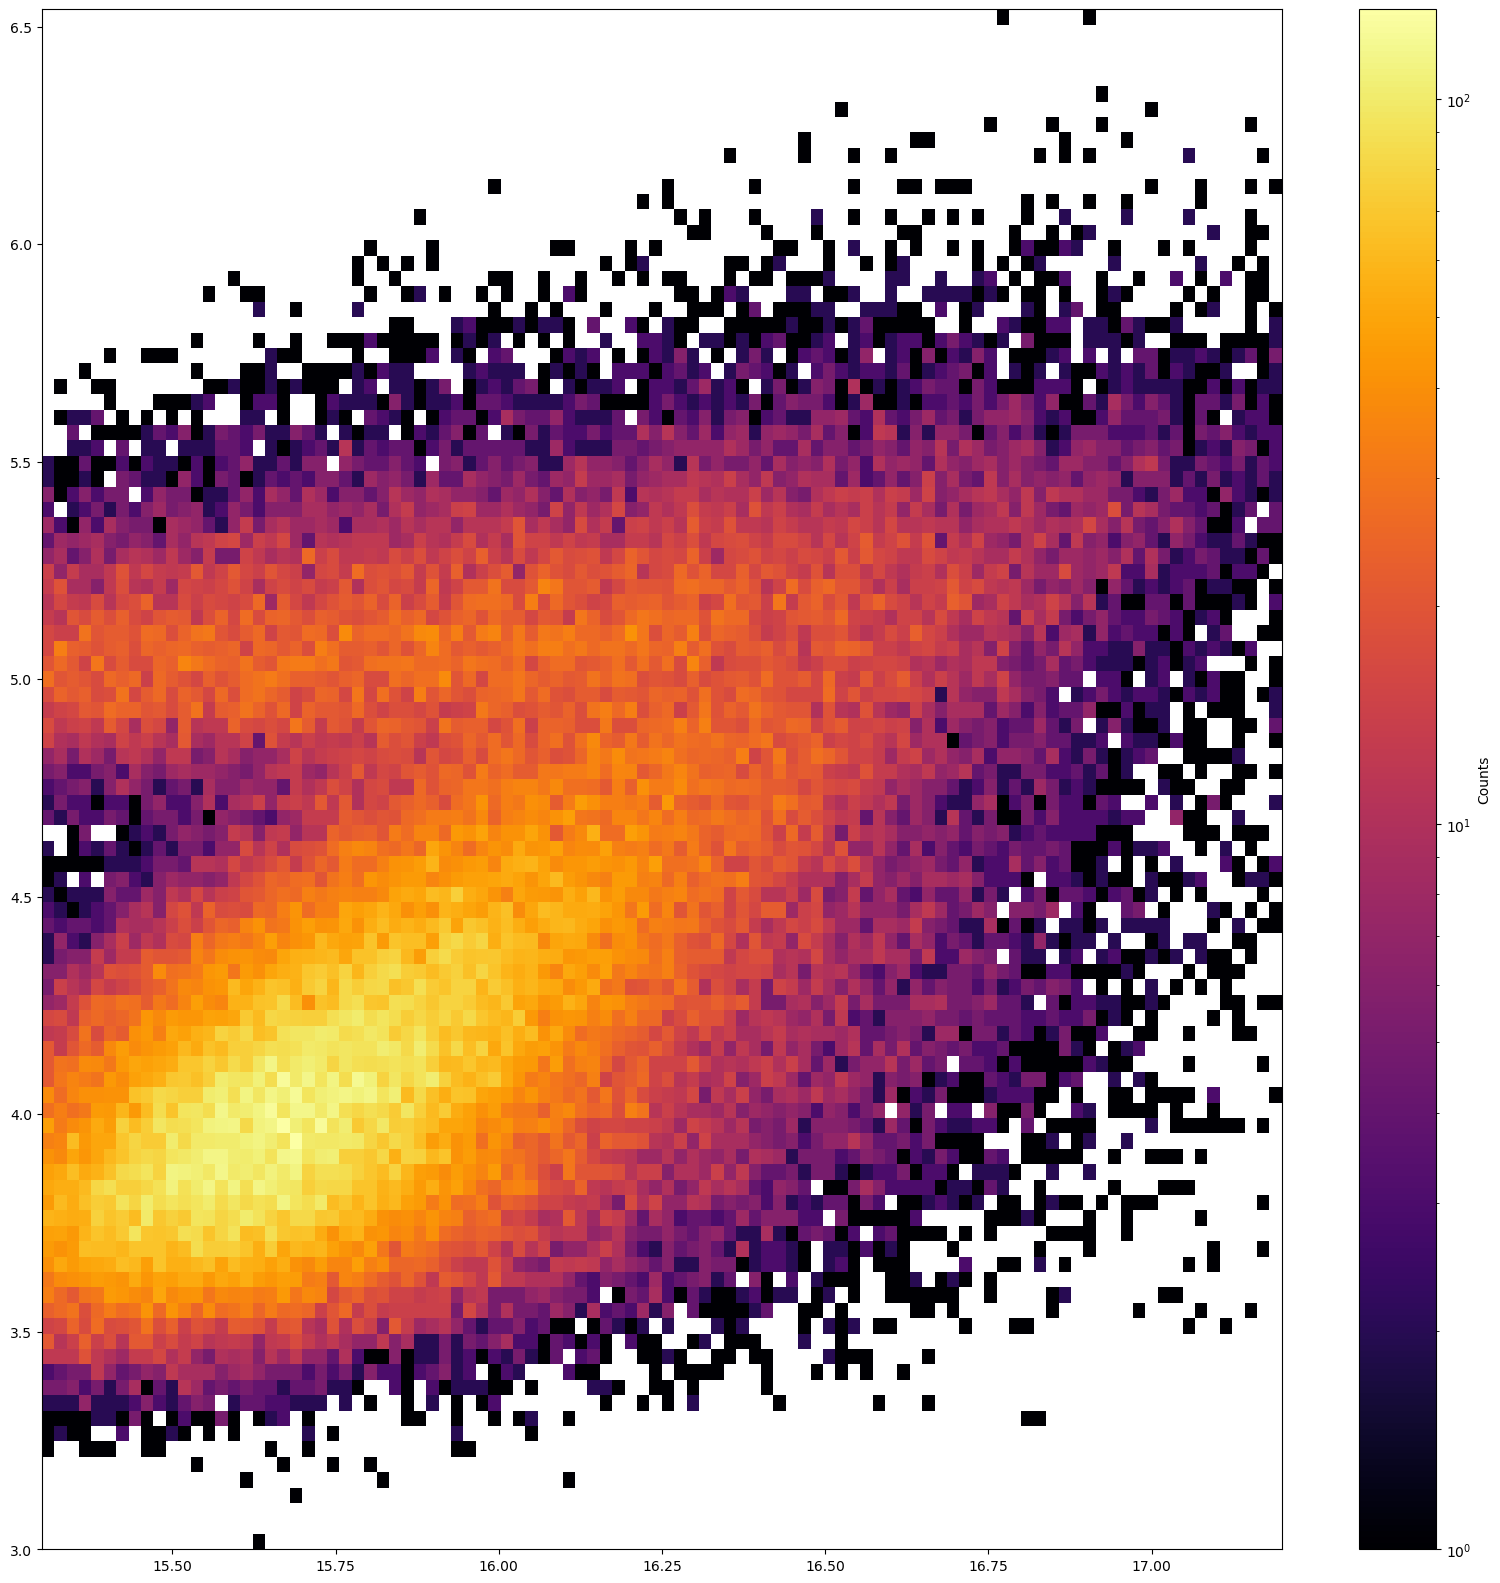

In [29]:
plt.figure(figsize = (20,20))
all_Es = 10**all_logEs
X = all_logEs
Y = np.log10(all_myEpreds.clip(min=1000))  
plt.hist2d(X, Y, bins=100, cmap='inferno', norm=mcolors.LogNorm())
plt.colorbar(label='Counts')

plt.figure(figsize = (20,20))
all_Es = 10**all_logEs
X = all_logEs
Y = np.log10(all_myEpreds.clip(min=1000))  

mask = (all_omegas>0.06)

plt.hist2d(X[mask], Y[mask], bins=100, cmap='inferno', norm=mcolors.LogNorm())
plt.colorbar(label='Counts')


Text(0.5, 1.0, 'My Epreds vs LogE with Omega cut removing 0.153 % events')

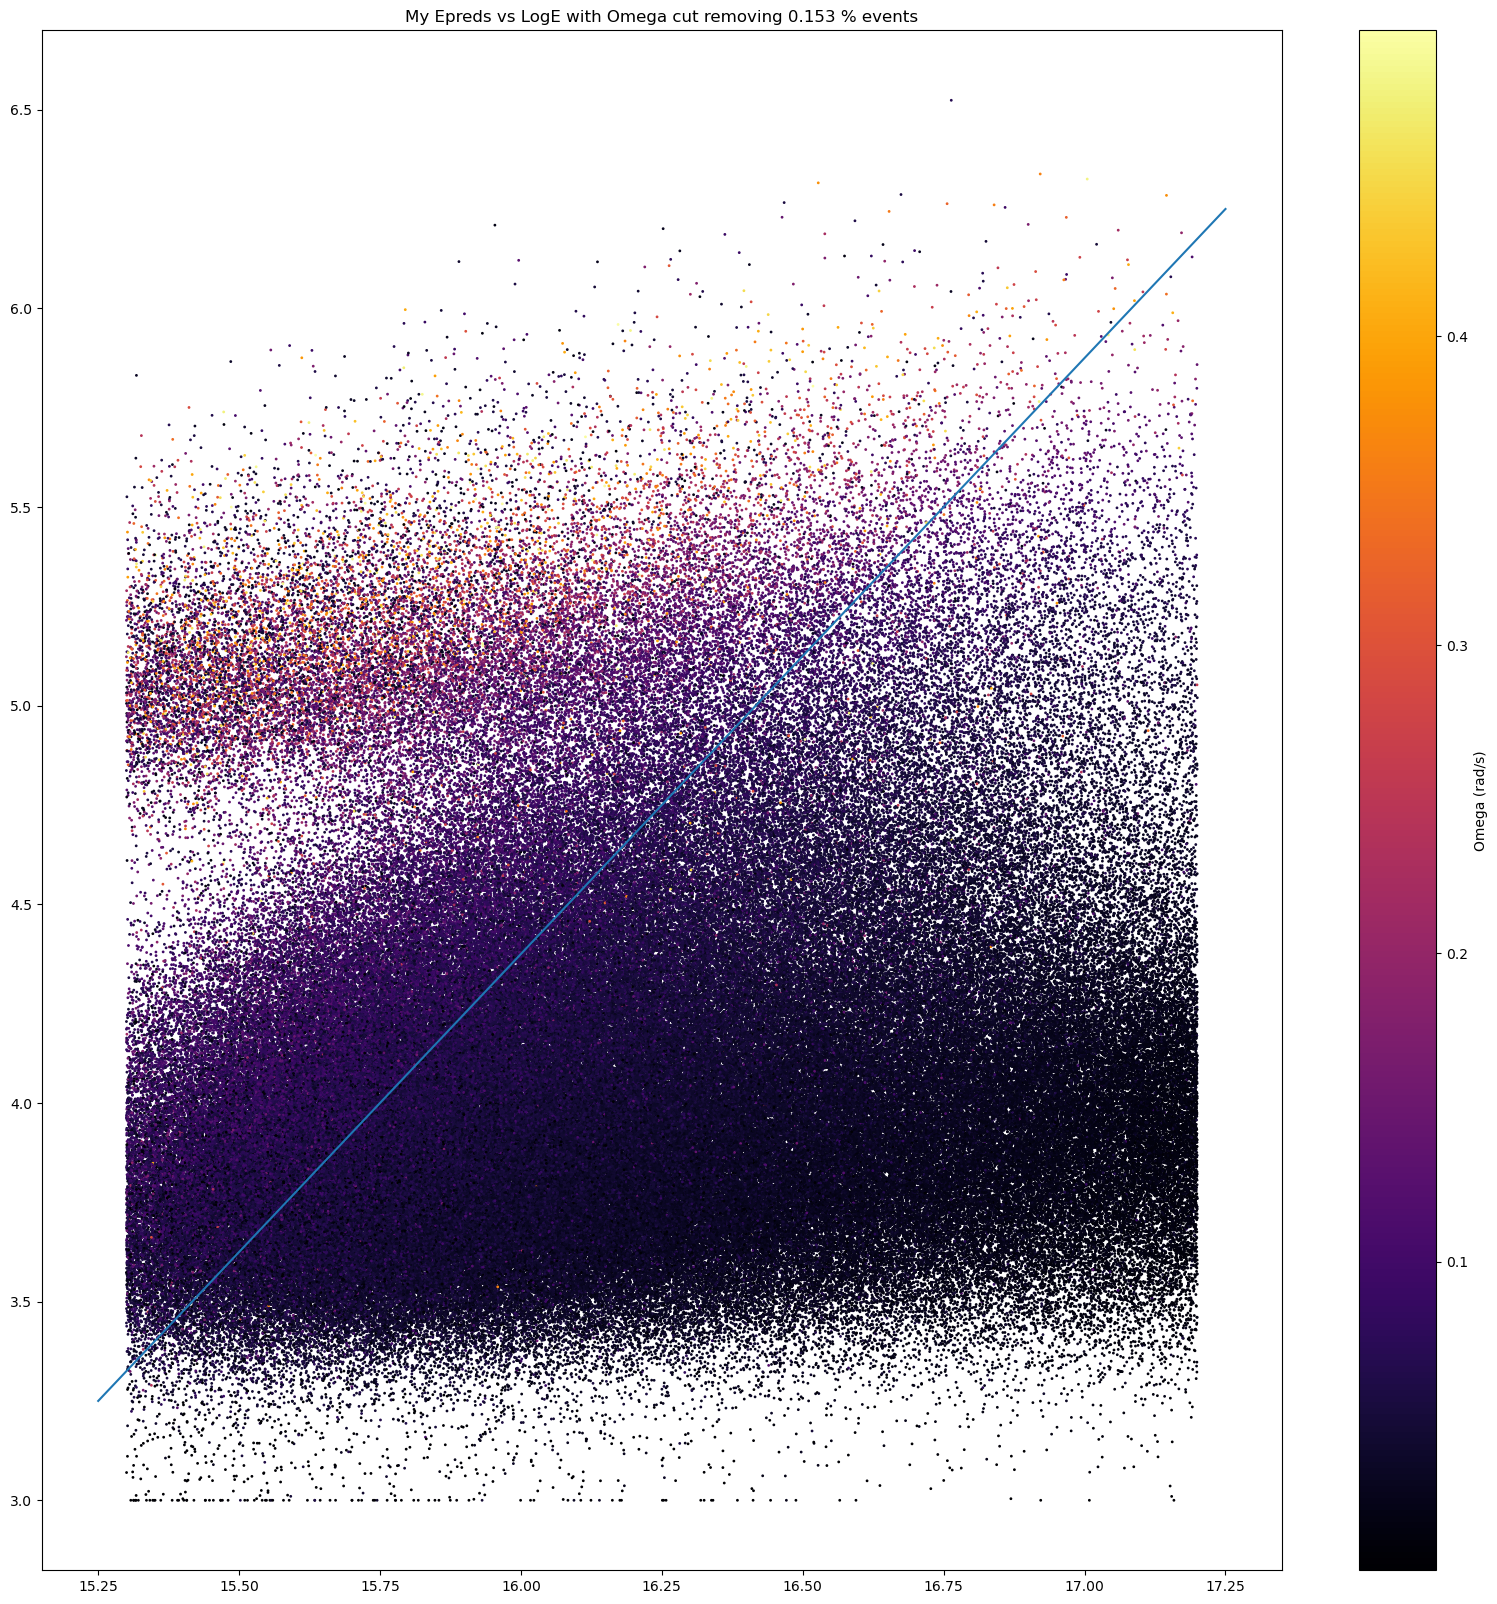

In [97]:
X = all_logEs
Y = np.log10(all_myEpreds.clip(min=1000))
C = (all_omegas)

plt.figure(figsize = (20,20))
mask = (all_omegas>0.0) * (all_omegas<0.5)
plt.scatter(X[mask], Y[mask],c = C[mask],\
             cmap='inferno',s=1)
plt.colorbar(label='Omega (rad/s)')
plt.plot([15.25,17.25],[3.25,6.25])
plt.title(f'My Epreds vs LogE with Omega cut removing {np.sum(~mask)/len(mask)*100:.3f} % events')

Text(0, 0.5, 'Log10 My Epreds (eV)')

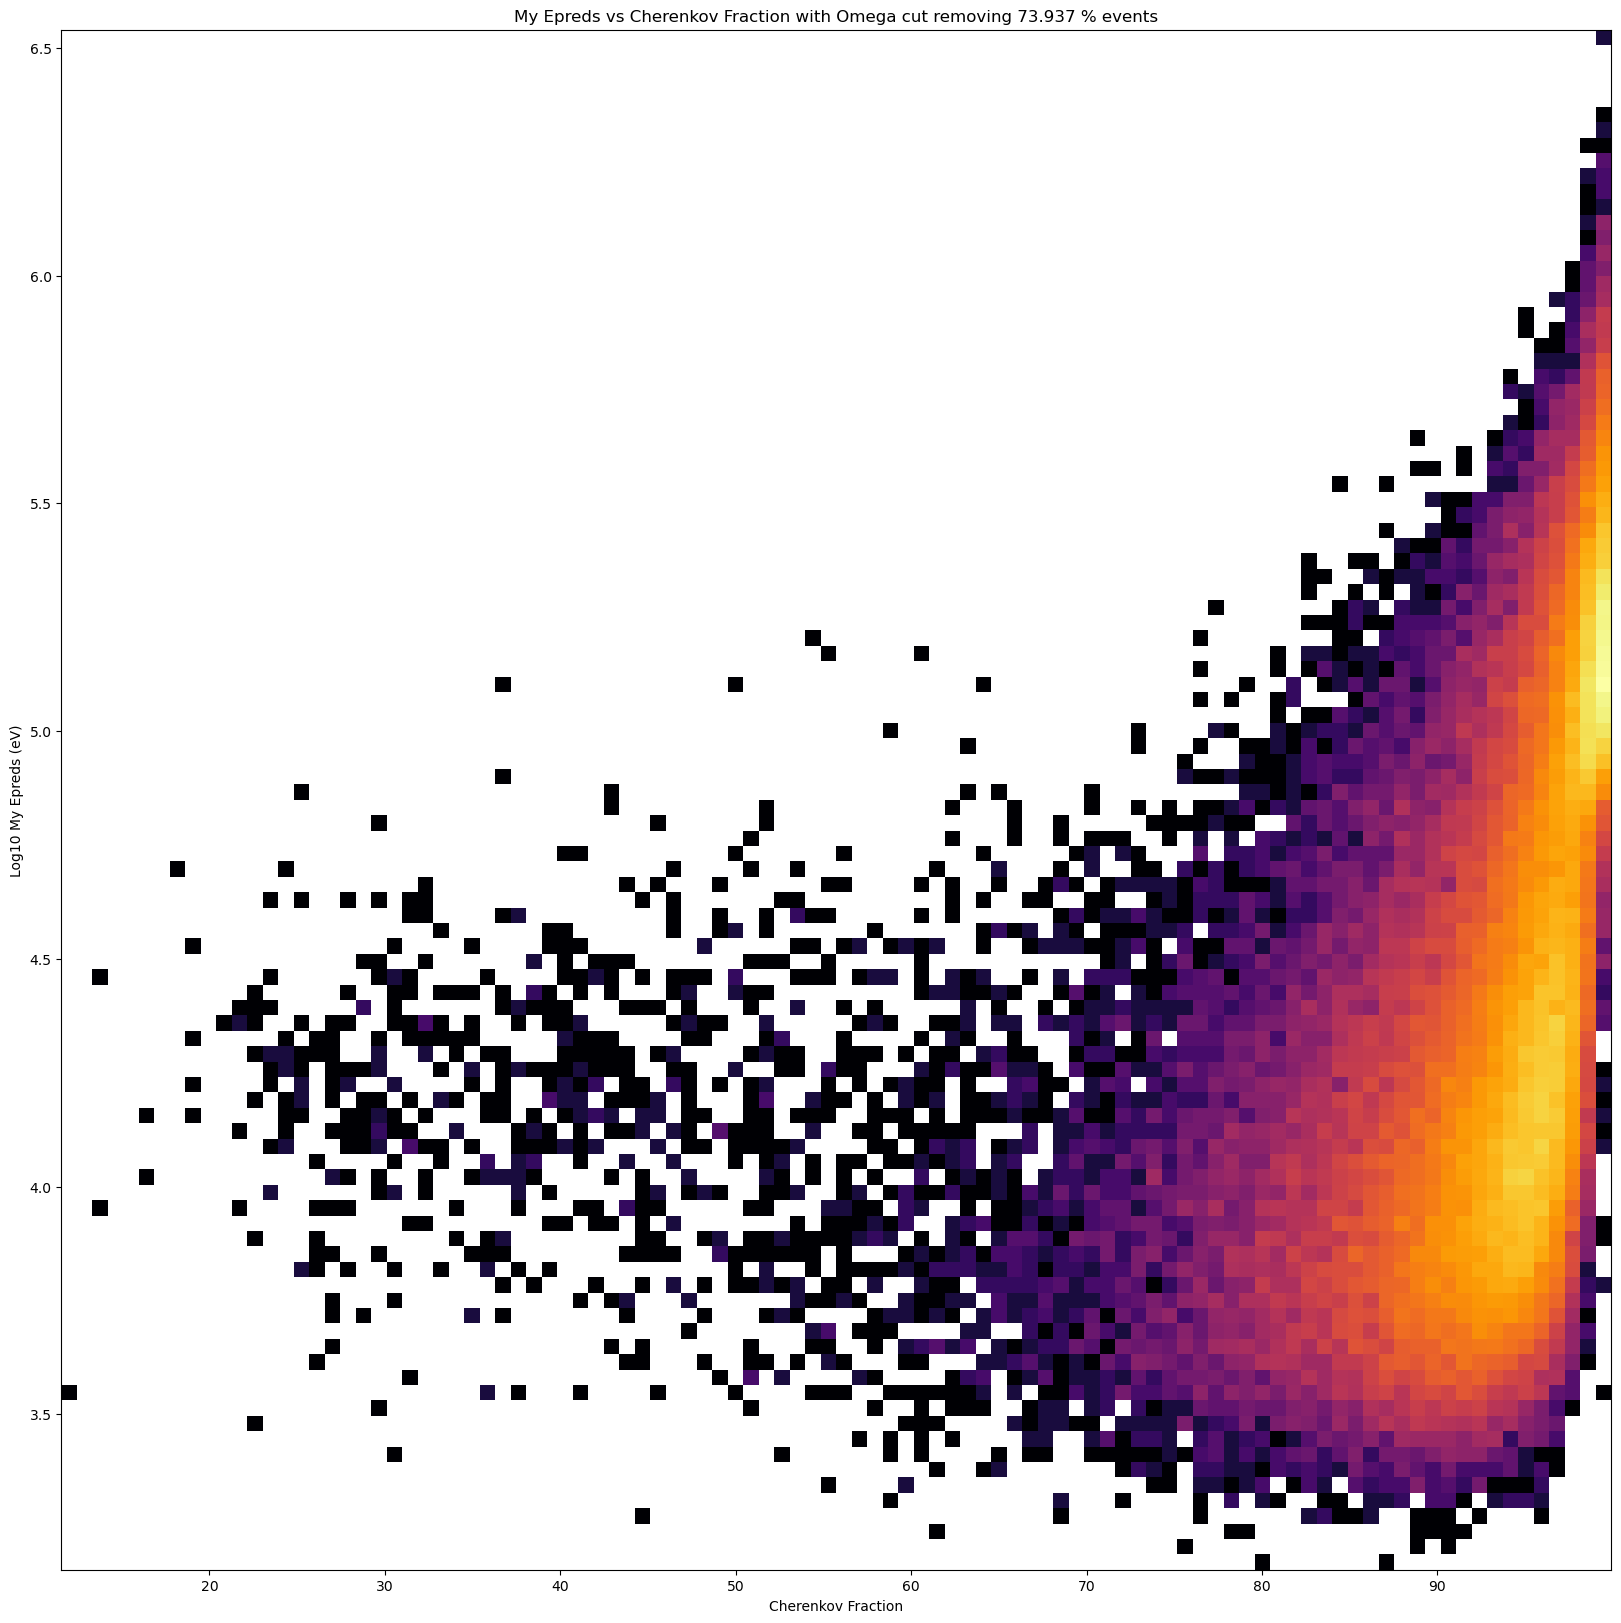

In [62]:
X = all_cherenkov_fractions
Y = np.log10(all_myEpreds.clip(min=1000))
C = np.log10(all_omegas)

mask = (all_omegas>0.065) * (all_omegas<10)

plt.figure(figsize= (20,20))
# plt.scatter(X[mask],Y[mask],c = C[mask],\
#              cmap='inferno', s=1)
# plt.colorbar(label='Omega (rad/s)')
plt.hist2d(X[mask], Y[mask], bins=100, cmap='inferno', norm=mcolors.LogNorm())
plt.title(f'My Epreds vs Cherenkov Fraction with Omega cut removing {np.sum(~mask)/len(mask)*100:.3f} % events')
plt.xlabel('Cherenkov Fraction')
plt.ylabel('Log10 My Epreds (eV)')

Text(0.5, 1.0, 'My Epreds vs Cherenkov Fraction with Omega cut removing 0.000 % events')

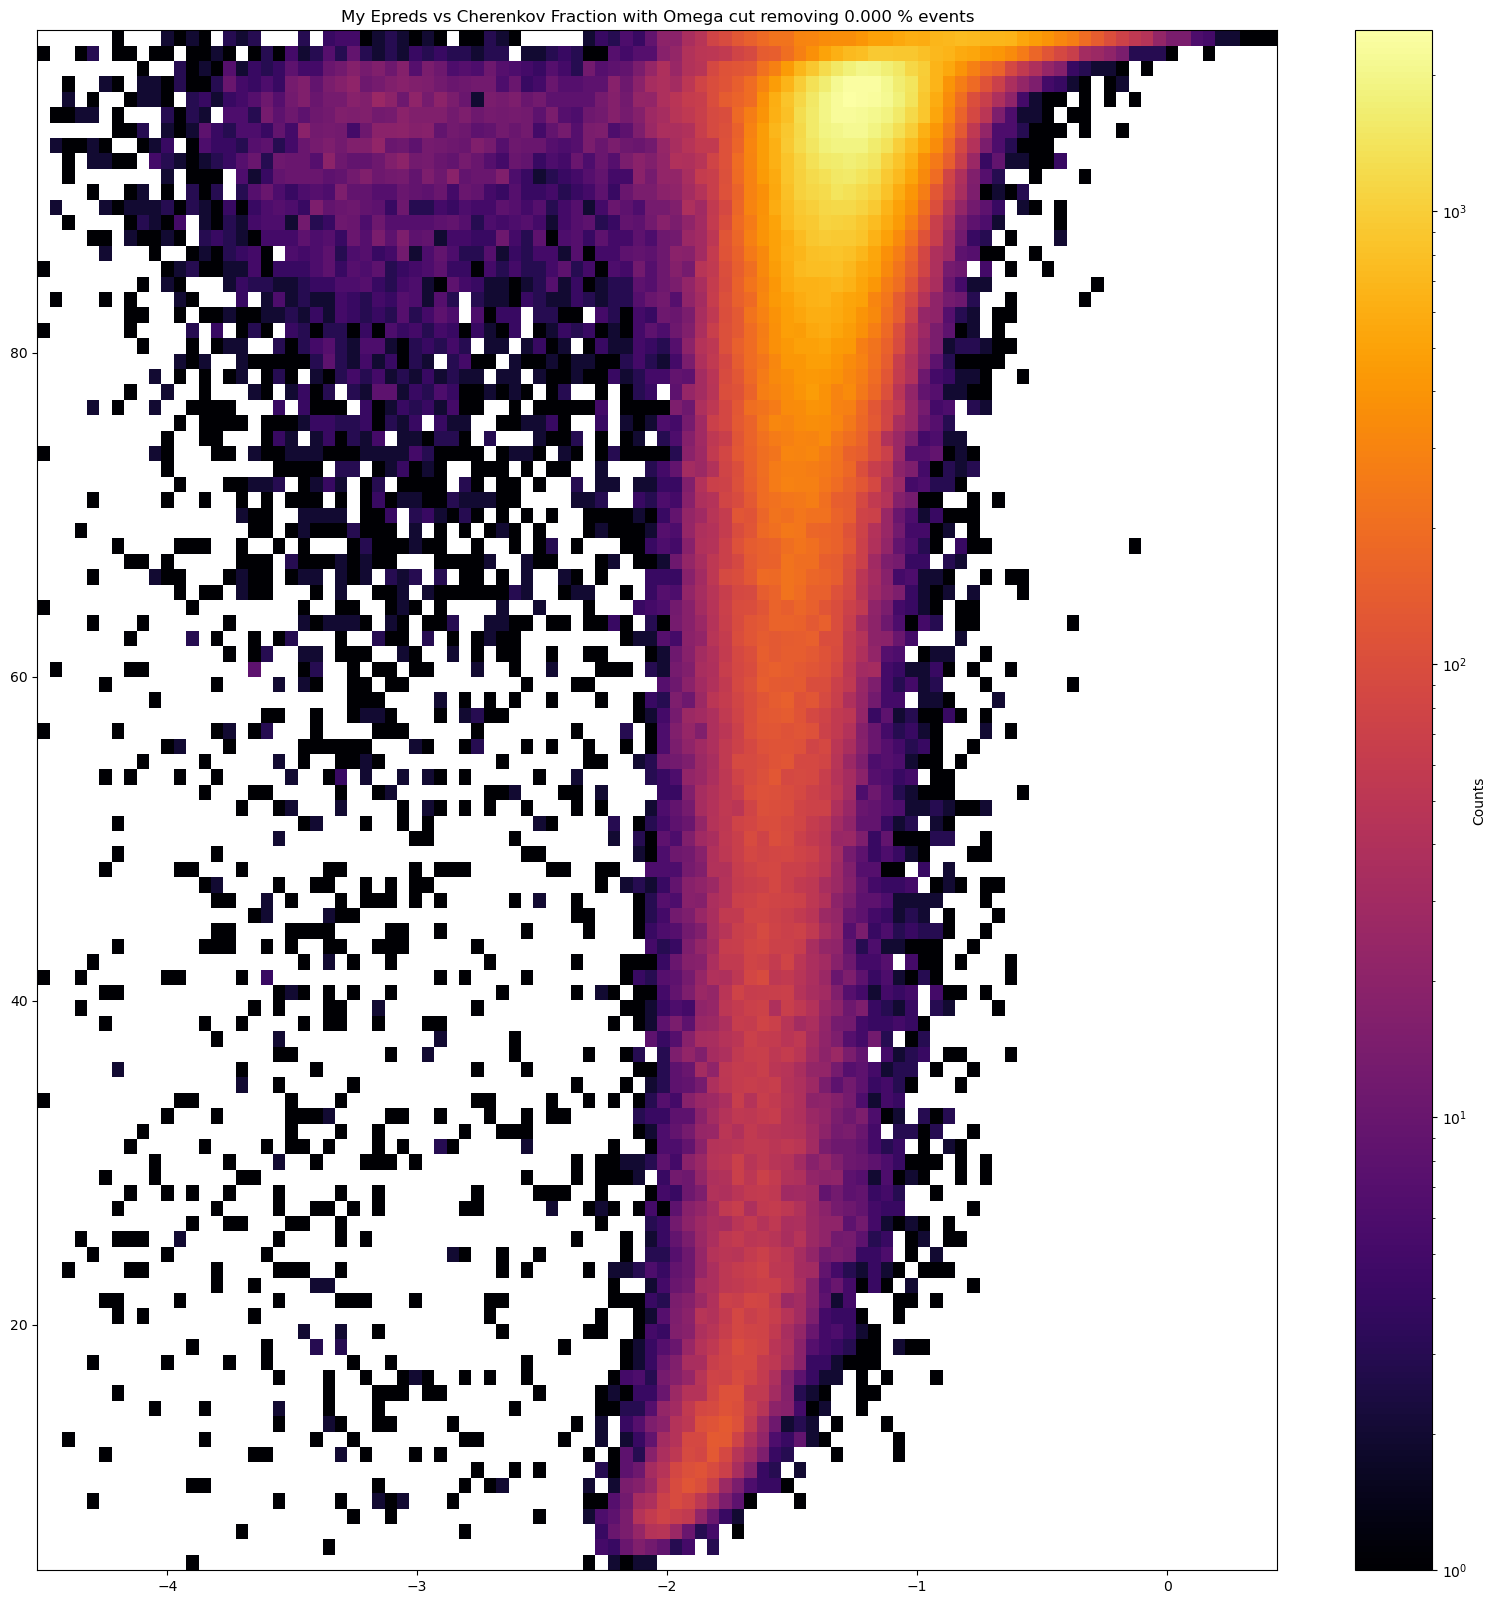

In [66]:
X = np.log10(all_omegas)
Y = all_cherenkov_fractions
# C = 

mask = (all_omegas>0.0) * (all_omegas<10)

plt.figure(figsize= (20,20))
# plt.scatter(X[mask],Y[mask],c = C[mask],\
#              cmap='inferno', s=1)
# plt.colorbar(label='Omega (rad/s)')
plt.hist2d(X[mask], Y[mask], bins=100, cmap='inferno', norm=mcolors.LogNorm())
plt.colorbar(label='Counts')
plt.title(f'My Epreds vs Cherenkov Fraction with Omega cut removing {np.sum(~mask)/len(mask)*100:.3f} % events')


Text(0.5, 1.0, 'My Epreds vs Cherenkov Fraction with Omega cut removing 0.000 % events')

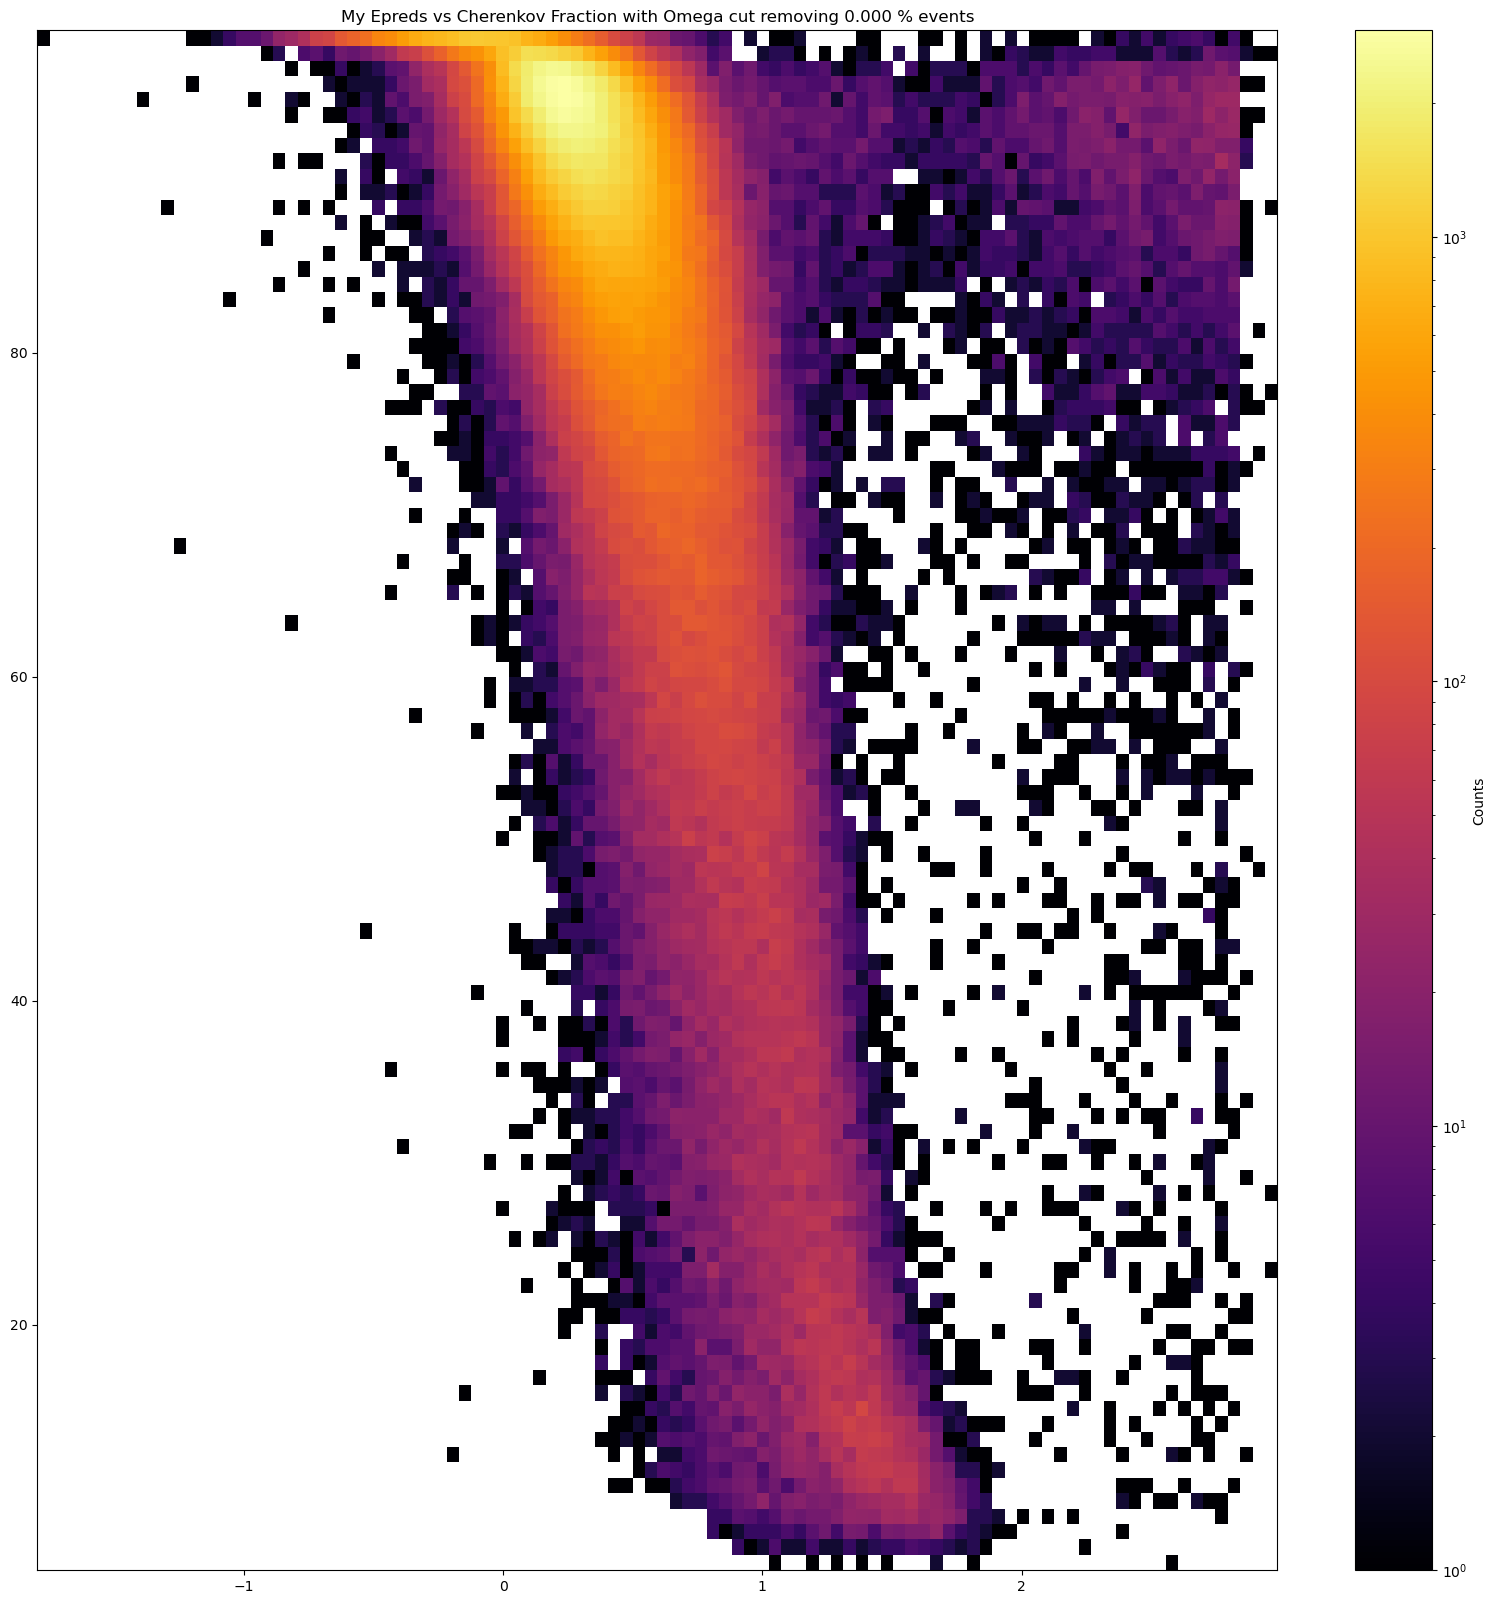

In [ ]:
X = np.log10(all_durations)
Y = all_cherenkov_fractions
# C = 

# mask = (all_omegas>0.0) * (all_omegas<10) 
mask = (all_event_classes != 10)

plt.figure(figsize= (20,20))
# plt.scatter(X[mask],Y[mask],c = C[mask],\
#              cmap='inferno', s=1)
# plt.colorbar(label='Omega (rad/s)')
plt.hist2d(X[mask], Y[mask], bins=100, cmap='inferno', norm=mcolors.LogNorm())
plt.colorbar(label='Counts')
plt.title(f'My Epreds vs Cherenkov Fraction with Omega cut removing {np.sum(~mask)/len(mask)*100:.3f} % events')


Text(0.5, 1.0, 'My Epreds vs Cherenkov Fraction with Omega cut removing 0.000 % events')

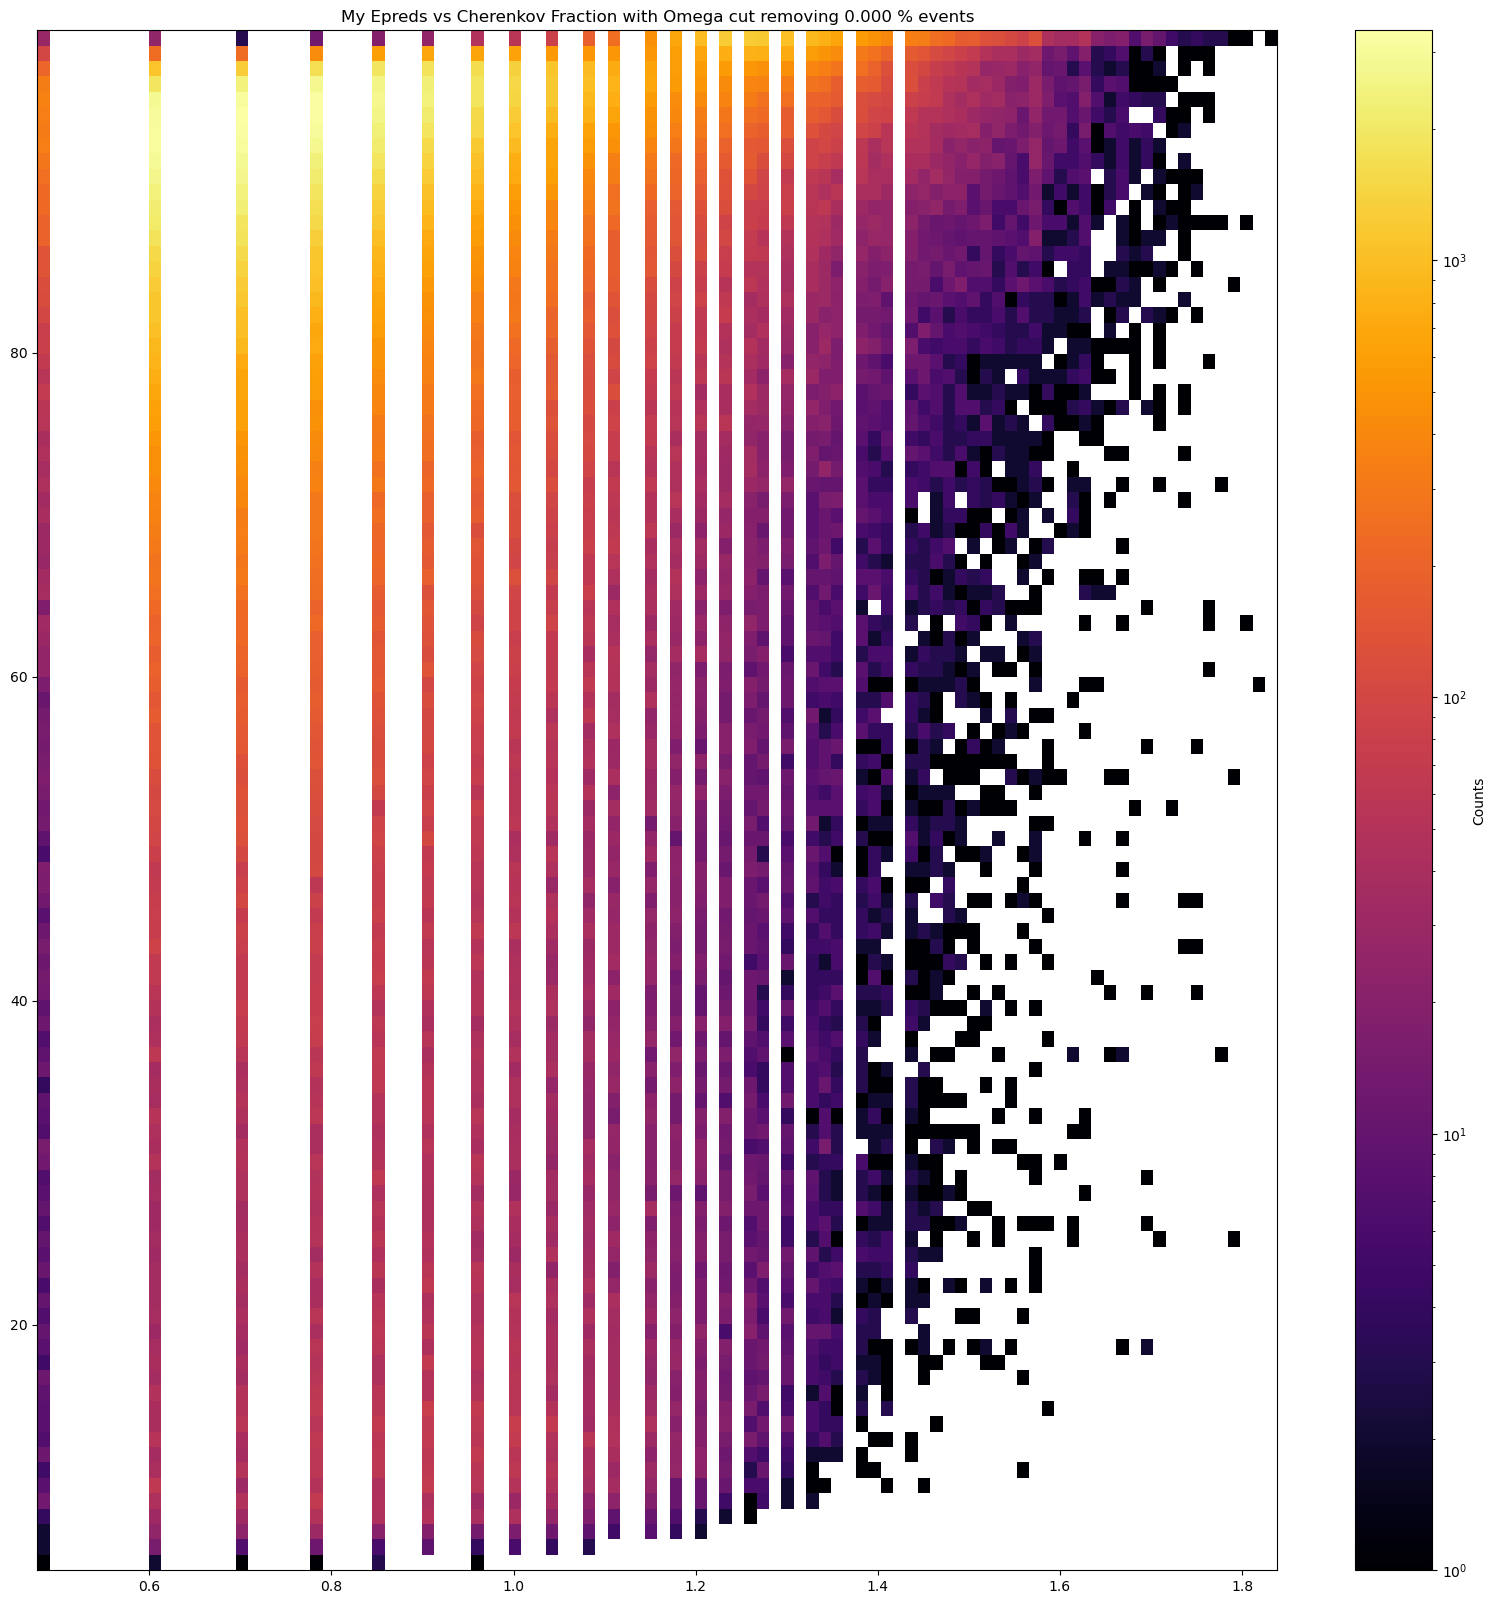

In [86]:
X = np.log10(all_multiplicities)
Y = all_cherenkov_fractions
# C = 

# mask = (all_omegas>0.0) * (all_omegas<10) 
mask = (all_event_classes != 10)

plt.figure(figsize= (20,20))
# plt.scatter(X[mask],Y[mask],c = C[mask],\
#              cmap='inferno', s=1)
# plt.colorbar(label='Omega (rad/s)')
plt.hist2d(X[mask], Y[mask], bins=100, cmap='inferno', norm=mcolors.LogNorm())
plt.colorbar(label='Counts')
plt.title(f'My Epreds vs Cherenkov Fraction with Omega cut removing {np.sum(~mask)/len(mask)*100:.3f} % events')


(array([24453., 43106., 55232., 56255., 49768., 41058., 33710., 27817.,
        23359., 19455.]),
 array([15.30000019, 15.48999977, 15.68000031, 15.87000084, 16.06000137,
        16.25      , 16.44000053, 16.63000107, 16.81999969, 17.01000023,
        17.20000076]),
 <BarContainer object of 10 artists>)

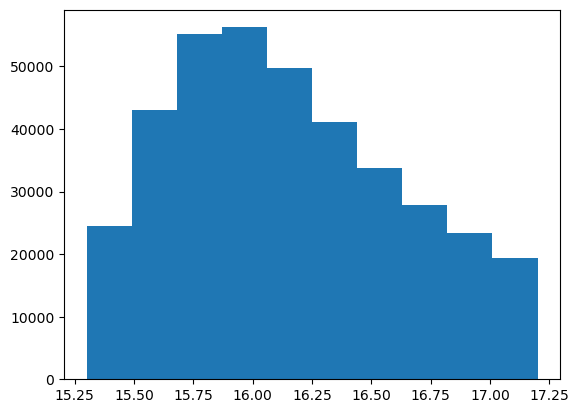

In [94]:
plt.hist(all_logEs)